# Stock price forecasting

# Modeling Random Forests and LSTM neural networks

The purpose of this section is to train two machine learning models -Random Forests and LSTM neural network- to predict the `Close` price of our test dataset, and assess their performance. In both cases we will investigate how the size of the test set affects the model's performance. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

## Random Forest

Random Forests are an ensemble learning method (namely, a method that combines the predictions of multiple individual models --often called "base models" or "learners"-- to improve the overall performance) used for both classification and regression. They operate by constructing multiple decision trees during training and outputting the class that is the mode (for classification) or the mean prediction (for regression) of the individual trees.

Random Forests work on the following three principles:

1. Bagging: Bagging (Bootstrap Aggregating) is an ensemble technique lying at the core of Random Forests. Each tree in the forest is built on a different subset of the data (drawn with replacement), which means that the individual trees are trained on diverse samples. This diversity reduces the chances of overfitting.

2. Feature Randomness: In addition to bagging, Random Forests also select a random subset of features at each split. This introduces more diversity into the tree-building process and further reduces the risk of overfitting.

3. Voting/Averaging: The final prediction of the Random Forest is an average (for regression) or a majority vote (for classification) of the predictions of all the trees. This aggregation helps in smoothing out the noise and anomalies of individual trees.

As generic features of Random Forests, we can mention:

1. Due to the averaging nature of Random Forests, they are less likely to overfit compared to individual decision trees. Nevertheless, they can overfit noisy data if not properly tuned.

2. They naturally consider nonlinearities and interactions between features.

3. They can handle large dataset with higher dimensionality, though they may become computationally intensive.

4. Importance Scoring: Random Forests can rank the importance of input variables.

5. They are insensitive to rescaling features. The splitting criterion in decision trees is based on purity scores, such as the Gini impurity or information gain. These criteria are not affected by the scale of the data. 

6. Flexibility: They can handle missing values and are not sensitive to outliers.

7. Parallelizable: Tree constructions can be done in parallel, making them suited for large datasets.

8. Less Interpretable: While an individual decision tree can be visualized and interpreted, a Random Forest is more of a "black box," making it harder to interpret how decisions are made.

We can argue that some of the features above make Random Forests an attractive model for stock price forecasting, as they can handle complex non-linearities of the stock market and capture interactions betwen features, and reduce overfitting (a common issue in stock price prediction) if properly tuned. Moreover, the ensemble nature of random forests can help in reducing variance and potentially provide a more stable prediction. On the other hand, the typical non-stationary of financial time-series (meaning their statistical properties change over time) presents a challenge for random forest models, as these do not take into account the temporal structure of time series data and assume that the underlying process generating the data does not change over time. Nevertheless, it is possible to engineer lagged features (values from previous time steps) to provide some context of the temporal structure. Depending on the behaviour of the stock at hand, random forest models might be more suited for understanding relationships and factors influencing stock prices rather than for making trading decisions.




First step is to import the Random Forest Regressor model:

In [2]:
# Import the RandomForestRegressor model
from sklearn.ensemble import RandomForestRegressor

### 1. Coca-Cola stock

#### Loading the data

We need to load the training and test features and target datasets we saved in the previous notebook. We are using the unscaled datasets as Random Forests are insensitive to scaling.

In [3]:
# Load the X_train, y_train, X_test and y_test datasets

X_train = pd.read_csv('X_train_KO.csv', parse_dates=True, index_col=0)
y_train = pd.read_csv('y_train_KO.csv', parse_dates=True, index_col=0)

X_test = pd.read_csv('X_test_KO.csv', parse_dates=True, index_col=0)
y_test = pd.read_csv('y_test_KO.csv', parse_dates=True, index_col=0)

In [4]:
X_train

,Open,High,Low,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC,OBV,P/E,Day,Month,Year
Date,,,,,,,,,,,,,,,,,,,,
1996-05-06,19.937500,20.218750,19.750000,10.236874,7170400,0.14,0.281250,54.166667,70.000000,20.167723,20.122550,0.045173,0.045976,-0.000803,-0.154321,-10631600,144.419643,6,5,1996
1996-05-07,20.218750,20.406250,20.156250,10.300159,6702800,0.14,0.125000,56.578947,83.333333,20.194804,20.138935,0.055869,0.047955,0.007914,1.244168,-3928800,145.312500,7,5,1996
1996-05-08,20.343750,20.687500,20.062500,10.474213,8292800,0.14,0.343750,65.853659,100.000000,20.270603,20.179569,0.091034,0.056571,0.034463,1.846154,4364000,147.767857,8,5,1996
1996-05-09,20.687500,20.937500,20.593750,10.474213,4820400,0.14,0.000000,71.052632,78.947368,20.334741,20.217194,0.117547,0.068766,0.048781,1.846154,4364000,147.767857,9,5,1996
1996-05-10,20.718750,20.968750,20.718750,10.616608,4942800,0.14,0.281250,68.571429,100.000000,20.432281,20.272865,0.159416,0.086896,0.072520,3.389831,9306800,149.776786,10,5,1996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,60.750000,62.290001,60.669998,59.126160,23064200,0.64,-0.070000,39.502762,18.965543,62.600185,63.125886,-0.525701,-0.299640,-0.226061,-3.218682,2802664700,95.843750,13,6,2022
2022-06-14,60.730000,60.889999,58.660000,57.504799,24620000,0.64,-2.110001,20.757061,8.850929,62.081695,62.837302,-0.755607,-0.390833,-0.364773,-6.088473,2778044700,92.546874,14,6,2022
2022-06-15,60.000000,60.639999,58.970001,57.931984,19684700,0.64,0.439999,24.358971,15.683207,61.710665,62.602687,-0.892022,-0.491071,-0.400951,-6.370628,2797729400,93.234372,15,6,2022


We save the features names for future use:

In [5]:
features = X_train.columns

#### Training the model

We now proceed to train our Random Forest model and make predictions on the testing dataset. We choose to use a Random Forest Regressor model with 5 trees (n_estimators=5) and set a random seed for reproducibility of our results (random_state=42).

In [6]:
# Initialize the random forest regressor
rf_model = RandomForestRegressor(n_estimators=5, random_state=42, n_jobs=-1)

# Fit the model on the training data
rf_model.fit(X_train, y_train.values.ravel())

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)


The performance of the model will be assessed by using the mean squared error (MSE):

In [7]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.566241967822413


This means that  that on average, our predictions are off by roughly 0.75 dollars from the true value, which we may consider a rather small error, especially for the reduced number of trees used.

In order to compare the predicted values of the target variable and its actual values we plot the corresponding series:

In [8]:
def plot_predictions(y_pred, y_test):
    """
    Plot the predicted values against the true values.
    
    Parameters:
    - y_pred: list or array-like of predicted values.
    - y_test: list or array-like of true values.
    """
    
    # Create a range of indices for the x-axis
    x = range(len(y_pred))
    
    # Plot the predicted values (y_pred) and the true values (y_test)
    plt.plot(x, y_pred, label='Predicted')
    plt.plot(x, y_test, label='Actual')
    
    # Set labels and title
    plt.ylabel('Closing Price')
    plt.xlabel('Time')
    plt.title('Predicted vs Actual Closing Price')
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.show()




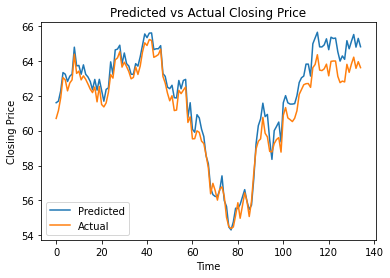

In [9]:
plot_predictions(y_pred, y_test)

We observe a quite good match between the predicted and actual Closing price distributions. Although the curves tend to slightly spread out from each other past around 90 timesteps, their shapes remain practically identical.

The size of the previous test set was quite small, only 2% of the total dataset. We are interested in investigating the performance of random forests in learning larger test sets. To that end, we are going to consider different test set sizes: 10%, 15% and 20%.

We first need to load the whole dataset:

In [11]:
df_KO = pd.read_csv('df_KO_.csv', parse_dates=True, index_col=0)

In [42]:
def split_data(df, test_size=0.02, target='Close'):
    '''
    Perform train-test split with respect to time series structure.

    Parameters:
    df: DataFrame, the input pandas DataFrame.
    test_size: float, the proportion of the dataset to include in the test split.
    target: str, the target variable to predict. Default is 'Close'.

    Returns:
    X_train, X_test, y_train, y_test : series, split datasets.
    '''

    # Ensure df is a pandas DataFrame
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Data should be a pandas DataFrame.")
    
    # Calculate the index at which to split the DataFrame into training and testing data
    split_index = int(len(df) * (1 - test_size))
    
    # Split the DataFrame into training and testing data
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]

    # Separate the features and the target variable in the training and testing sets
    X_train = train_data.drop([target], axis=1)
    y_train = train_data[target].to_frame() 
    X_test = test_data.drop([target], axis=1)
    y_test = test_data[target].to_frame() 

    X_train['Day'] = X_train.index.day
    X_train['Month'] = X_train.index.month
    X_train['Year'] = X_train.index.year

    X_test['Day'] = X_test.index.day
    X_test['Month'] = X_test.index.month
    X_test['Year'] = X_test.index.year

    
    return X_train, X_test, y_train, y_test


In [84]:
# Perform a data split with test size 3%
X_train1, X_test1, y_train1, y_test1 = split_data(df_KO, test_size=0.03)

X_train1 = X_train1[['Open','High', 'Low','Adj Close']]
X_test1 = X_test1[['Open','High', 'Low','Adj Close']]

rf_model1 = RandomForestRegressor(n_estimators=5,random_state=42, n_jobs=-1)

# Fit the model on the training data
rf_model1.fit(X_train1, y_train1.values.ravel())

# Make predictions on the testing data
y_pred = rf_model1.predict(X_test1)

# Compute and print MSE
mse = mean_squared_error(y_test1, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.634829830013316


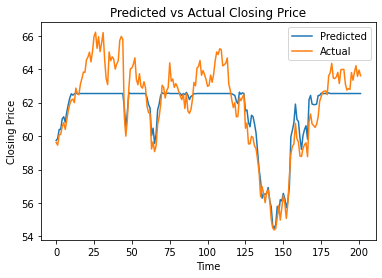

In [85]:
plot_predictions(y_pred, y_test1)

We already observe a pattern that will be present for larger test set sizes: the presence of segments where the prediction flattens to a noisy horizontal line, alternating with segments where the prediction adjusts relatively well to the actual data. Changing the values of the hyperparameters does not solve this issue. 

In [88]:
X_train2, X_test2, y_train2, y_test2 = split_data(df_KO, test_size=0.1)

In [89]:
# Fit the model on the training data
rf_model1.fit(X_train2, y_train2.values.ravel())

# Make predictions on the testing data
y_pred = rf_model1.predict(X_test2)

# Compute and print MSE
mse = mean_squared_error(y_test2, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 5.677182937718932


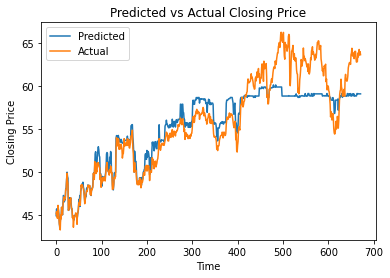

In [90]:
plot_predictions(y_pred, y_test2)

In [91]:
X_train3, X_test3, y_train3, y_test3 = split_data(df_KO, test_size=0.15)

In [92]:
# Fit the model on the training data
rf_model1.fit(X_train3, y_train3.values.ravel())

# Make predictions on the testing data
y_pred = rf_model1.predict(X_test3)

# Compute and print MSE
mse = mean_squared_error(y_test3, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 45.256783625915396


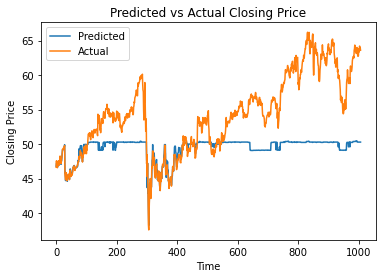

In [94]:
plot_predictions(y_pred, y_test3)

In general, the larger the size of the test set, the larger is the MSE due to larger regions having a constant prediction. From now on we restricti ourselves to the case of test set size 2%: this might seem small a priori, but it covers around 140 days of prediction, which is satisfactory in the context of short-term market forecasting.

#### Variable importance

We shall now perform a feature importance analysis, using the `feature_importances_` attribute, which provides a score for each feature of the data, with higher scores indicating more importance.

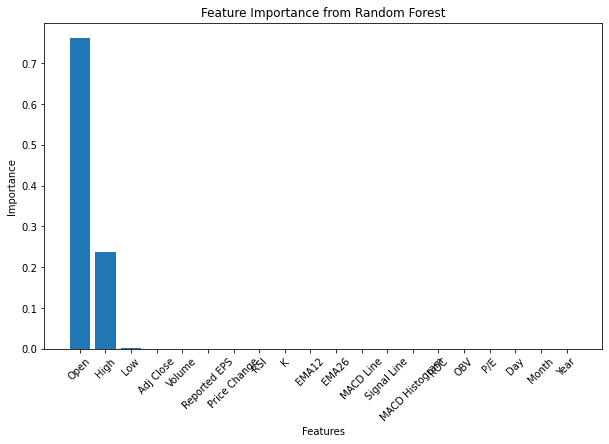

In [53]:
importances = rf_model.feature_importances_

sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.bar(features, importances[sorted_idx])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.xticks(rotation=45)
plt.show()

It turns out that the feature importance in this model is essentially split between the `Open` and `High` features, with respective importances around 0.75 and 0.25. We know that additiona features can add extra variance and worsen the performance of a random forest, as well as producing a dilution of important features at each split in a tree, which can make the model less accurate. It is worth then to check if there is a subset of features that minimizes the MSE.



In this case, we have checked that for `test_size=0.02` the minimal subset of features is composed by `Open`, `High` and `Low`. 

In [95]:
X_train = X_train[['Open','High', 'Low']]
X_test = X_test[['Open','High', 'Low']]

# Fit the model on the training data
rf_model.fit(X_train, y_train.values.ravel())

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.16611107032949576


Note that the MSE is reduced from 0.566 to 0.166 (around 70% reduction) only by selecting the most important features.

On the other hand, the presence of plateaus for higher values of the test set size is not solved by restricting the training set to the most important features.

From now on we focus on the model trained with only `Open`, `High` and `Low` features. 

#### Cross-validaton

It is time now to perform model validation using cross-validation. 

When dealing with time series data, you can't use traditional k-fold cross-validation because it shuffles the data, which can result in data leakage: information from the future might be used to predict the past. Instead, you use time series cross-validation where data is split in a way that respects the order of the data. This is achieved using the `tscv.split(X)` method. Essentially, it is used to obtain indices for train/test splits suitable for time series data, ensuring that the chronological order of the data is maintained and preventing any information leakage.

In [96]:
from sklearn.model_selection import TimeSeriesSplit

# Number of splits. For example, if n_splits=5, it will produce 5 train/test sets.
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the Random Forest Regressor
model = RandomForestRegressor()

# Define a list for the MSE scores
mse_scores = []

# Perform the time series cross-validation
for train_index, test_index in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Calculate the mean and standard deviation of MSE across folds
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"Mean MSE: {mean_mse:.4f} (+/- {std_mse:.4f})")


Mean MSE: 0.1344 (+/- 0.0021)


The mean MSE obtained in the cross-validation process is very similar to the MSE obtained in our test set, with a very small standard deviation. This gives us confidence that the model is showing consistent performance across different subsets of the training data (as observed during cross-validation) and on unseen data (test set). This is a good indication that the model is not overfitting to specific portions of the training data.

#### Hyperparameter tuning

Although our previous model performs quite well on the test set with a small MSE, we can still further adjust the hyperparameters to check if a better performance is possible. We should then weight how much the MSE improves versus how complicated the model gets. 

For this purpose, we will use `RandomizedSearchCV`. Unlike `GridSearchCV`, which evaluates the model for every combination of hyperparameters provided, `RandomizedSearchCV` randomly selects a subset of hyperparameter combinations. The number of combinations to try is specified by the `n_iter` parameter. Here we consider 100 random combinations of hyperparameter values and select the one among these that has a minimal MSE. We then check whether this MSE is less than the one of the model with the hyperparameter values previously used.

In [99]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(3, 100),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None] + list(np.arange(1, 30)),
    'min_samples_split': np.arange(2, 50),
    'min_samples_leaf': np.arange(1, 50),
    'bootstrap': [True, False]
}

# Initialize RandomForestRegressor instance
rf = RandomForestRegressor()

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=100, 
    scoring='neg_mean_squared_error', cv=tscv, 
    verbose=1, n_jobs=-1, random_state=42
)

# Fit the model
random_search.fit(X_train, y_train.values.ravel())

# Print the best parameters
print(random_search.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 63, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 9, 'bootstrap': True}


In [100]:
# Initialize the random forest regressor
rf_model = RandomForestRegressor(n_estimators=63, min_samples_split=8, min_samples_leaf=3, max_features='sqrt', max_depth=9, bootstrap=True, random_state=42, n_jobs=-1)

# Fit the model on the training data
rf_model.fit(X_train, y_train.values.ravel())

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)


In [101]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.15678970258562205


We have found a different choice of hyperparameters that slightly reduces the MSE from 0.166 to 0.156. Nevertheless, the new model is way more complicated: the number of trees has grown from 5 to 63, and other hyperparameters have also been increased.  It does not seem reasonable to complicate our model so much for such a little improvement in MSE. 

We should keep in mind that RandomSearchCV does not sweep over all the parameter grid we have defined, it only consider random points of the grid. So it is still possible that some choice of parameters reduces the MSE still rendering the model simple. In any case, an MSE of 0.166 is quite satisfactory, especially given the results of the cross-validation study.

### 2. Tesla stock

#### Loading the data

In [117]:
# Load the X_train, y_train, X_test and y_test datasets

X_train = pd.read_csv('X_train_TSLA.csv', parse_dates=True, index_col=0)
y_train = pd.read_csv('y_train_TSLA.csv', parse_dates=True, index_col=0)

X_test = pd.read_csv('X_test_TSLA.csv', parse_dates=True, index_col=0)
y_test = pd.read_csv('y_test_TSLA.csv', parse_dates=True, index_col=0)

In [118]:
X_train

,Open,High,Low,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC,OBV,P/E,Day,Month,Year
Date,,,,,,,,,,,,,,,,,,,,
2010-08-24,1.283333,1.314000,1.263333,1.280000,10096500,-0.0271,-0.062000,41.184842,43.509628,1.281007,1.301034,-0.020027,-0.025088,0.005060,7.262595,-6639000,-47.232471,24,8,2010
2010-08-25,1.277333,1.332000,1.237333,1.326667,7549500,-0.0271,0.046667,46.469911,83.666960,1.288032,1.302933,-0.014901,-0.023050,0.008149,13.068233,910500,-48.954500,25,8,2010
2010-08-26,1.326000,1.351333,1.306667,1.316667,6507000,-0.0271,-0.010000,51.129968,78.666966,1.292437,1.303950,-0.011513,-0.020743,0.009230,7.805728,-5596500,-48.585497,26,8,2010
2010-08-27,1.316667,1.324667,1.300000,1.313333,5694000,-0.0271,-0.003334,50.702179,77.000004,1.295652,1.304645,-0.008994,-0.018393,0.009400,4.898807,-11290500,-48.462474,27,8,2010
2010-08-30,1.313333,1.346000,1.307333,1.324667,10992000,-0.0271,0.011334,56.249947,82.666973,1.300116,1.306129,-0.006013,-0.015917,0.009904,3.759788,-298500,-48.880700,30,8,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,271.829987,284.089996,270.309998,276.010010,58076900,0.7600,0.680023,50.841713,13.106492,291.359990,290.652674,0.707316,3.359731,-2.652415,-5.518089,17552375800,363.171065,26,9,2022
2022-09-27,283.839996,288.670013,277.510010,282.940002,61925200,0.7600,6.929993,49.587400,29.041177,290.064607,290.081365,-0.016758,2.684433,-2.701191,-6.500110,17614301000,372.289477,27,9,2022
2022-09-28,283.079987,289.000000,277.570007,287.809998,54664800,0.7600,4.869995,49.206864,40.239144,289.717744,289.913116,-0.195371,2.108472,-2.303844,-5.247737,17668965800,378.697365,28,9,2022


In [109]:
features = X_train.columns

#### Training the model

In [110]:
# Initialize the random forest regressor
rf_model2 = RandomForestRegressor(n_estimators=17, random_state=42, n_jobs=-1)

# Fit the model on the training data
rf_model2.fit(X_train, y_train.values.ravel())

# Make predictions on the testing data
y_pred = rf_model2.predict(X_test)


In [111]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 24.10017321535006


On average, the model's predictions deviate from the actual prices by about 4.91 dollars. This is about 6.55 times higher than in the case of the Coca-Cola stock (0.75 dollars); however the scale of prices is also higher from 2020, reaching up to 400 dollars with high volatility (which is more than x6 times the highest value of the Coca-Cola stock price, around 60 dollars). Thus, it seems that this second random forest model is performing comparably to the first one, especially taking into account the larg volatility of TSLA stock. 

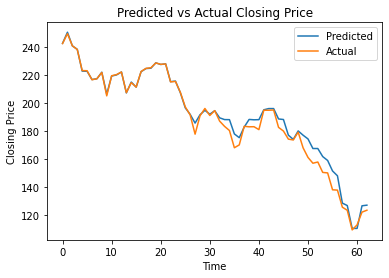

In [113]:
plot_predictions(y_pred, y_test)

We observe a perfect match up to day 25. Afterwards the predicted time series captures the general contracting trend, but showing values between 5% and 10% higher then the actual data over certain intermediate periods of time. Nevertheless, both predicted and actual time series end up convegenging during the last days within the test set.

#### Variable importance

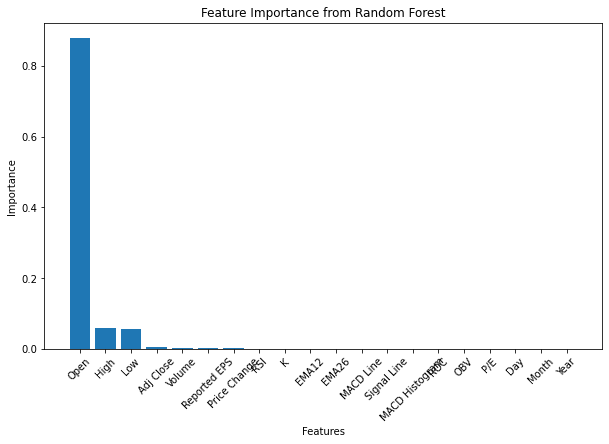

In [114]:
importances = rf_model2.feature_importances_

sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.bar(features, importances[sorted_idx])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.xticks(rotation=45)
plt.show()

In this case most of the feature importance is concentrated in the `Open` price (0.86), followed by `High` and `Low` (with around 0.7). The rest of features have essentially insignificant importance.

We find that, if we only consider the subset of features `Open`, `High`, `Low` and `Adj Close` the MSE is drastically minimized from 24.10 to 6.70.

In [126]:
X_train = X_train[['Open','High', 'Low','Adj Close']]
X_test = X_test[['Open','High', 'Low','Adj Close']]

# Fit the model on the training data
rf_model2.fit(X_train, y_train.values.ravel())

# Make predictions on the testing data
y_pred = rf_model2.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 6.700998439567296


Therefore we focus in the sequel on this model with truncated number of features. 

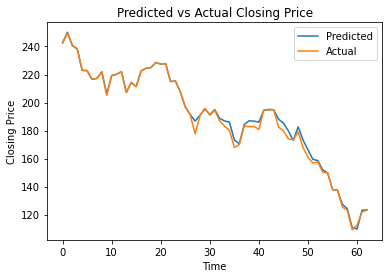

In [127]:
plot_predictions(y_pred, y_test)

#### Cross-validation

In [120]:
# Number of splits. For example, if n_splits=5, it will produce 5 train/test sets.
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the Random Forest Regressor
model = RandomForestRegressor()

mse_scores = []

# Perform the time series cross-validation
for train_index, test_index in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Calculate the mean and standard deviation of MSE across folds
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"Mean MSE: {mean_mse:.4f} (+/- {std_mse:.4f})")

Mean MSE: 6.3794 (+/- 0.5304)


The MSE from the test set is quite close to the mean MSE from cross-validation, with a standard devition of around 8% of the mean MSE. This suggests that the model performs consistently on different subsets of the data and generalizes fairly well to unseen data. On average, the model has a squared error of about 6.38 units, and this error can vary by about 0.53 units across different data splits. 

#### Hyperparameter tuning

In this case we can expect the possibility of improving the MSE of our model by hyperparameter tuning up to at least 5.95. Again, we should assess if the complexity of the new model is worth the reduction of MSE. 

Let us perform an exhaustive `RandomizedSearchCV` picking 5000 random combinations of hyperparameters values. 

In [121]:
param_dist = {
    'n_estimators': np.arange(3, 100),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None] + list(np.arange(1, 30)),
    'min_samples_split': np.arange(2, 50),
    'min_samples_leaf': np.arange(1, 50)
}

#  RandomForestRegressor instance
rf = RandomForestRegressor()

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=5000, 
    scoring='neg_mean_squared_error', cv=tscv, 
    verbose=1, n_jobs=-1, random_state=42
)

# Fit the model
random_search.fit(X_train, y_train.values.ravel())

# Print the best parameters
print(random_search.best_params_)

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
{'n_estimators': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 11}


In [124]:
# Initialize the random forest regressor
rf_model = RandomForestRegressor(n_estimators=18, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=11, random_state=42, n_jobs=-1)

# Fit the model on the training data
rf_model.fit(X_train, y_train.values.ravel())

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

In [125]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 4.914689431382637


We find that without further introducing much complexity we can reduce the MSE to 4.91. This only requires adding one more tree to the forest, increasing `min_samples_split` from 2 to 5 and imposing a reasonable maximal depth of 11. 

## Long-Short-Term-Memory neural network

LSTM networks are a type of Recurrent Neural Network (RNN) that are designed to remember patterns in sequential data over long-term time. Introduced by Hochreiter and Schmidhuber in 1997, LSTMs were designed to overcome the limitations of traditional RNNs, namely the issues related to the vanishing and exploding gradient problems. These challenges made it difficult for RNNs to capture long-term dependencies in sequence data, a problem that LSTMs solve.

The key innovation in LSTMs is the introduction of memory cells and three multiplicative gates: the input, forget, and output gates. These components allow LSTMs to regulate the flow of information, determining what to retain, discard, or pass on to the next time step. As a result, LSTMs can effectively learn and remember patterns over long sequences, making them especially suitable for tasks involving sequential data such as time series forecasting, natural language processing, and speech recognition.

Here we apply LSTMs to the problem of stock price forecasting. LSTMs can model intricate patterns and dependencies in historical stock price data, which might be overlooked or deemed infeasible by traditional models. By leveraging their proficiency in handling sequential data and effectively capture long-term dependencies, LSTMs have proved to be an excellent tool in forecasting future stock prices with high degree of accuracy.

Concretely, our goal is to make predictions for the `Close` column in our dataset. Due to the nature of LSTM, past values of the `Close` variable (appropriately preprocessed) will be considered as input features for making the prediction. This means that the `Close` variable will act both as a feature and the target, in contradistinction with typical machine learning scenarios where features and the target variable are clearly separated. This requires a further preprocessing of the data based on creating sequences of a certain number of past observations to make the prediction, which we will explain later on. 

We will consider two scenarios: feeding the LSTM only just past values of `Close` (univariate) and the itnroduction of additional features (multivariate).  

#### Univariate LSTM

Since the performance of LSTMs are sensitive to feature scaling, the first step is to perform a train/test split and rescale our dataset. We define a function that takes as input our dataset filename and returns the dataframe, the scaled and unscaled versions of the train and
test sets constructed out of just the `Close` column (using a 80-20 split) and the scaler, that we will need to unscale our predictions in the end.

In [5]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# This function reads our csv file and returns the dataframe, train set, test set, scaled train set, scaled test set and scaler

def scale_dataframe(filename):
    # Load data into DataFrame 
    df = pd.read_csv(filename)

    # Compute the number of data points for 80% of the data
    train_size = int(0.8 * len(df))

    # Split into train and test sets
    train = df[['Close']][:train_size]
    test = df[['Close']][train_size:]

    # Scale the features and target together
    scaler = MinMaxScaler(feature_range=(0,1))

    # Fit the scaler using only the training data and transform
    train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=['Close'])

    # Scale the test data
    test_scaled = pd.DataFrame(scaler.transform(test), columns=['Close'])
    
    return df, train, test, train_scaled, test_scaled, scaler


In [18]:
df, train, test, train_scaled, test_scaled, scaler = scale_dataframe('KO.csv')

In order to train our LSTM network, we need a further preprocessing of our data that will render it into a suitable format that can be fed to the network. In time series forecasting with LSTM, it is common to use a certain number of previous steps to predict the next step. This is often referred to as a 'sliding window' approach. 


We will define a function `create_dataset` that creates this sliding window, taking a time series dataset and a parameter `look_back` as inputs. The `look_back` parameter is the number of previous time steps to use as input variables for the prediction. The function will return two outputs:  a 2D numpy array `X` where each row corresponds to a sequence of `look_back` number of previous values from the dataset, and a 1D numpy array `Y` where each value corresponds to the next value in the dataset that follows the sequence in `X`. `X` contains the input features for our LSTM model, whereas `Y` is the target variable that our LSTM model will aim to predict.

In [20]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data.iloc[i:(i+seq_length)].values
        y = data.iloc[i+seq_length]  # removed .values
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# Specify the sequence length
seq_length = 60




Now we use the previosuly defined function to create the actual sequences from the train and test sets:

In [21]:
# Create sequences from train and test data
X_train, y_train = create_sequences(train_scaled['Close'], seq_length)
X_test, y_test = create_sequences(test_scaled['Close'], seq_length)

There is yet another subtlety we should take care of. The LSTM layer in Keras expects an input in the form of a 3D array, where the dimensions represent:

1. batch_size: the number of samples in a batch.
2. time_steps: the number of time steps in a single input sequence. For time series data, this would be the length of a sequence.
3. features: the number of features at each time step.

We must ensure that our data is in the right shape for the LSTM to process it.

In [22]:
# Reshape the inputs to be suitable for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

By reshaping with (X_train.shape[0], X_train.shape[1], 1), we are essentially adding an extra dimension to the data to indicate that there is just one feature at every time step.

Now we are ready to define our LSTM model. In order to do so we need to import the relevant TensorFlow and Keras libraries.

In [4]:
import tensorflow as tf

# Set a random seed for reproducibility of results
np.random.seed(42)
tf.random.set_seed(42)

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from pandas.tseries.offsets import DateOffset

2023-08-15 18:33:14.565766: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-15 18:33:14.922326: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-15 18:33:14.925053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 18:33:16.568699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Our LSTM model architecture will consist of three LSTM layers of 50 units, each of them followed by a dropout layer to prevent overfitting. The final layer is a dense layer that outputs into a single continuous value, which represent the prediction in a forecasting task (recall we are doing a one-day-ahead prediction). Having in the dense layer a single unit and no activation function defined makes the model suitable for regression, as this is what produces a single continuous value as output. 

We will define a class LSTMModel that encapsulates the architecture of our LSTM neural network, as we will need to use several instances of the model.

In [23]:

class LSTMModel:
    # Call the '__init__' method to perform initializations and set up attributes
    def __init__(self, input_shape=(None, 1)):
        self.input_shape = input_shape

        # Call the '_build_model' method to construct the actual LSTM and store it in the 'self.model' attribute
        self.model = self._build_model()
        
    # Define the architecture of the LSTM neural network
    def _build_model(self):
        model = Sequential()
        
        model.add(LSTM(units=50, return_sequences=True, input_shape=self.input_shape)) # This LSTM layer will output a sequence with the same length as the input sequence
        model.add(Dropout(0.2))

        model.add(LSTM(units=50, return_sequences=True))
        model.add(Dropout(0.2))

        model.add(LSTM(units=50))
        model.add(Dropout(0.2))

        model.add(Dense(units=1))

        return model


In [13]:
from keras.regularizers import l2

class LSTMModel2:
    def __init__(self, input_shape, l2_reg_strength=0.05):
        self.input_shape = input_shape
        self.l2_reg_strength = l2_reg_strength
        
        # Call the '_build_model' method to construct the actual LSTM and store it in the 'self.model' attribute
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()

        # Using instance variable for regularization strength
        model.add(LSTM(units=50, return_sequences=True, input_shape=self.input_shape, 
                       kernel_regularizer=l2(self.l2_reg_strength), 
                       recurrent_regularizer=l2(self.l2_reg_strength)))
        model.add(Dropout(0.2))
        
        model.add(LSTM(units=50, 
                       kernel_regularizer=l2(self.l2_reg_strength), 
                       recurrent_regularizer=l2(self.l2_reg_strength)))
        model.add(Dropout(0.2))
        
        model.add(Dense(1))
        return model

Using the `summary()' method we can display the architecture of our model. It provides a quick overview of all the layers that make up our model, along with the shape and number of parameters (weights and biases) in each layer. 

In [24]:
# Print out a summary of the model
lstm_model = LSTMModel((None, 1))
lstm_model.model.summary()


2023-08-14 23:51:18.129249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-14 23:51:18.131720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-14 23:51:18.133897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, None, 50)          10400     
                                                                 
 dropout_18 (Dropout)        (None, None, 50)          0         
                                                                 
 lstm_19 (LSTM)              (None, None, 50)          20200     
                                                                 
 dropout_19 (Dropout)        (None, None, 50)          0         
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_20 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [8]:
# Print out a summary of the model
lstm_model = LSTMModel2((None, 1),l2_reg_strength=0.01)
lstm_model.model.summary()


2023-08-14 20:38:46.150671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-14 20:38:46.155584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-14 20:38:46.158647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 50)          10400     
                                                                 
 dropout (Dropout)           (None, None, 50)          0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


2023-08-14 20:38:46.478764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-14 20:38:46.481719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-14 20:38:46.484347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

We can plot the graphical representation of this network using `plot_model`:

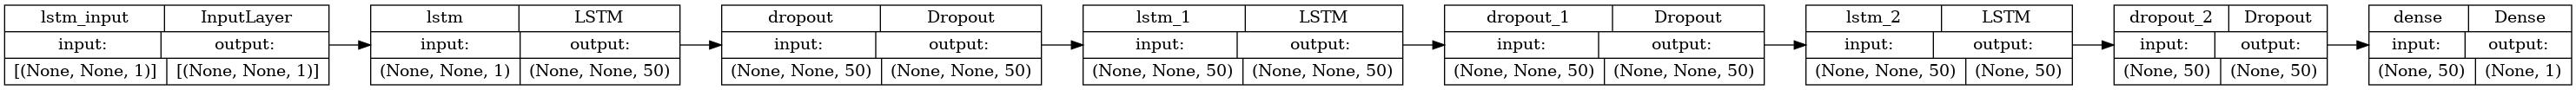

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(lstm_model.model, to_file='model.png', show_shapes=True, rankdir='LR')

Now we need to configure our model for training using the `compile` method. We choose to work with the Adam optimizer and to minimize the Mean Squared Error.

In [25]:
lstm_model.model.compile(optimizer='adam', loss='mean_squared_error')

We will sue the `ModelCheckpoint` callback as a way to save the model at different points during training. The checkpointer in this code will monitor the model's validation loss during the training, and whenever the validation loss improves (namely, decreases), it saves the current weights of the model to the file 'weights_best.hdf5'.

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5', 
    verbose = 2, 
    save_best_only = True
)


Finally we proceed to the training phase.

In [27]:
lstm_model.model.fit(
    X_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25


2023-08-14 23:51:35.501057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-14 23:51:35.503564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-14 23:51:35.505653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

167/167 [==============================] - 21s 93ms/step - loss: 0.0113
Epoch 2/25
167/167 [==============================] - 15s 88ms/step - loss: 0.0034
Epoch 3/25
167/167 [==============================] - 15s 88ms/step - loss: 0.0032
Epoch 4/25
167/167 [==============================] - 15s 89ms/step - loss: 0.0027
Epoch 5/25
167/167 [==============================] - 15s 88ms/step - loss: 0.0028
Epoch 6/25
167/167 [==============================] - 15s 90ms/step - loss: 0.0025
Epoch 7/25
167/167 [==============================] - 15s 91ms/step - loss: 0.0022
Epoch 8/25
167/167 [==============================] - 15s 91ms/step - loss: 0.0022
Epoch 9/25
167/167 [==============================] - 15s 90ms/step - loss: 0.0020
Epoch 10/25
167/167 [==============================] - 15s 90ms/step - loss: 0.0019
Epoch 11/25
167/167 [==============================] - 15s 88ms/step - loss: 0.0019
Epoch 12/25
167/167 [==============================] - 15s 88ms/step - loss: 0.0017
Epoch 13/25


We can now make the pediction on our test set and rescale it back to the scale of the original dataset.

In [28]:
# Compute the predicted values on the test set
test_predict = lstm_model.model.predict(X_test)
# Undo the scaling transformation on the predicted values 'test_predict' and the actual test values 'y_test'
test_predict = scaler.inverse_transform(test_predict)



2023-08-14 23:58:01.630685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-14 23:58:01.633283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-14 23:58:01.635481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

41/41 [==============================] - 3s 35ms/step


In [29]:
y_test_reshaped = y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test_reshaped)

Finally we plot our prediction versus the actual time-series and compute the MSE.

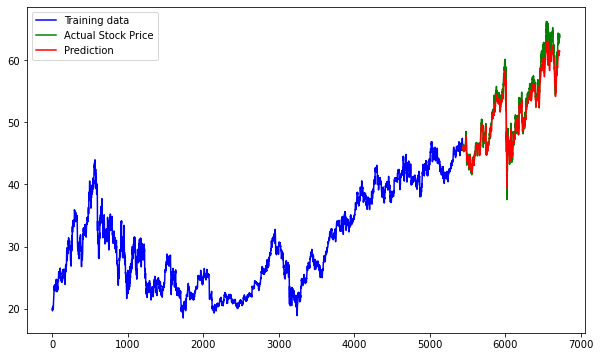

In [17]:
plt.figure(figsize=(10,6))
plt.plot(df.index[:len(train)+seq_length], df['Close'][:len(train)+seq_length], color='blue', label='Training data')
plt.plot(df.index[len(train)+seq_length:-1], df['Close'][len(train)+seq_length:-1], color='green', label='Actual Stock Price')
plt.plot(df.index[len(train)+seq_length:-1], test_predict, color='red', label='Prediction')
plt.legend()
plt.show()

Focusing on the test set:

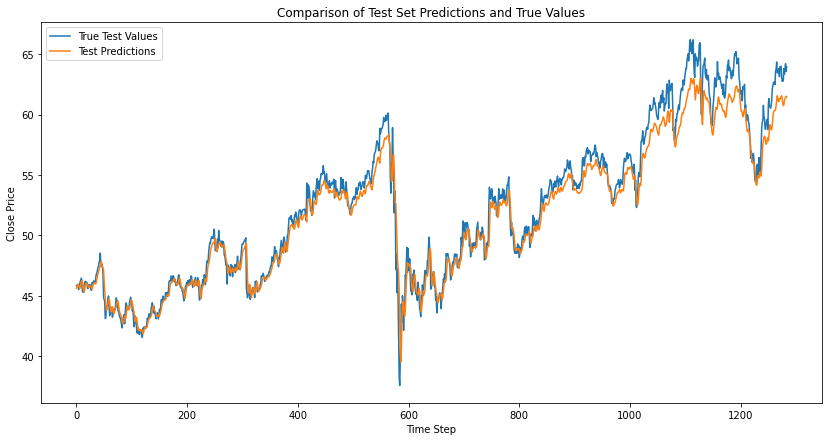

In [18]:
# Plot test predictions and actual values
plt.figure(figsize=(14,7))
plt.plot(y_test, label='True Test Values')
plt.plot(test_predict, label='Test Predictions')
plt.title('Comparison of Test Set Predictions and True Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Visually we already notice a remarkably good match. Let us compute the Mean Square Error:

In [19]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, test_predict)
print(mse)

1.639335581642787


This is a quite small error, especially for the timeframe we are considering (more than 1200 days, in other words ). Recall that our Random Forest model yielded a similar error but for a test set 10 times smaller, which clearly indicates the superiority of the LSTM model in learning stock price time series. 

There is yet one caveat: despite this great ability to learn time series data, it might be that our model is suffering from overfitting. We will perform a cross-validation analysis to study possible overfitting issues.

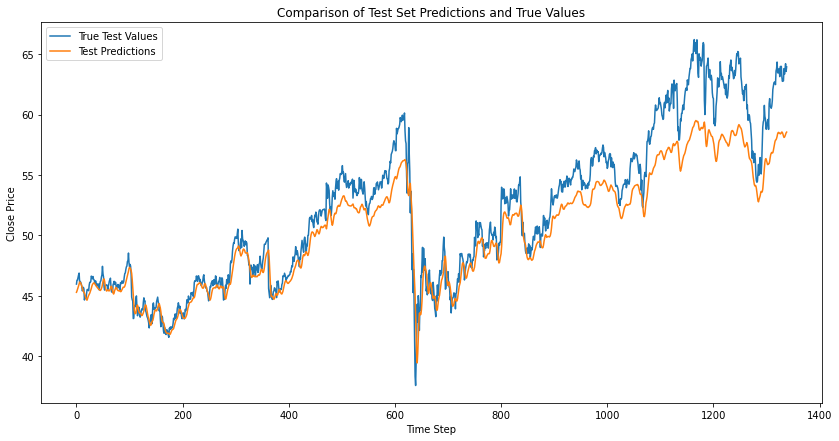

In [16]:
# Plot test predictions and actual values
plt.figure(figsize=(14,7))
plt.plot(y_test, label='True Test Values')
plt.plot(test_predict, label='Test Predictions')
plt.title('Comparison of Test Set Predictions and True Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# 20

In [17]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, test_predict)
print(mse)

6.032648907815051


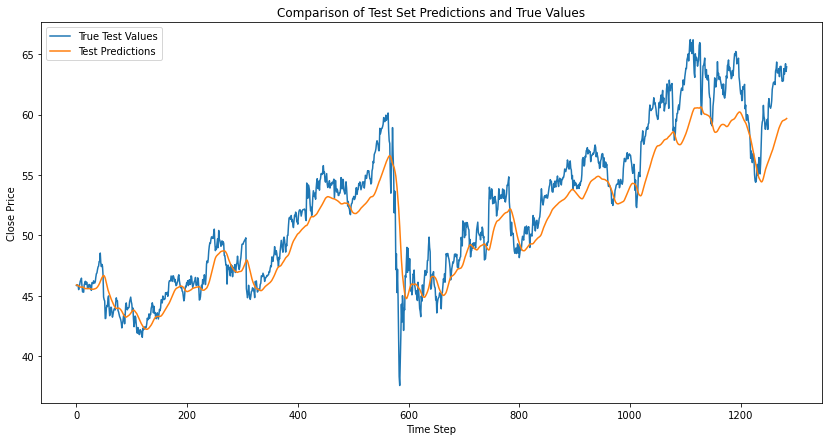

In [22]:
# Plot test predictions and actual values
plt.figure(figsize=(14,7))
plt.plot(y_test, label='True Test Values')
plt.plot(test_predict, label='Test Predictions')
plt.title('Comparison of Test Set Predictions and True Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, test_predict)
print(mse)

5.917133622917304


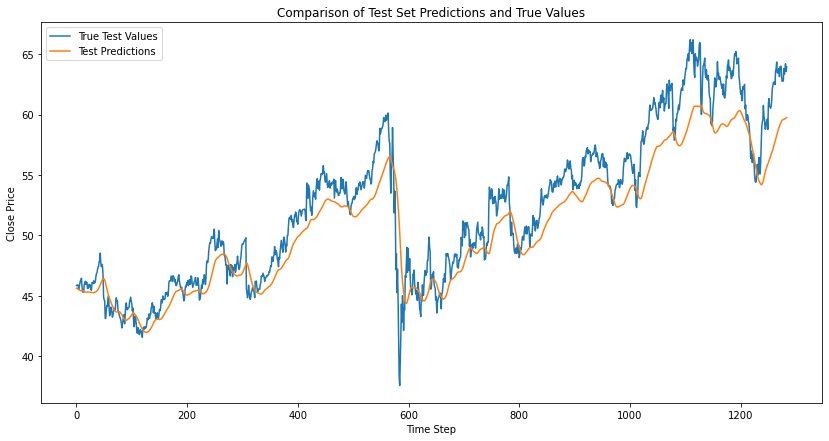

In [16]:
# Plot test predictions and actual values
plt.figure(figsize=(14,7))
plt.plot(y_test, label='True Test Values')
plt.plot(test_predict, label='Test Predictions')
plt.title('Comparison of Test Set Predictions and True Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, test_predict)
print(mse)

6.243862865094393


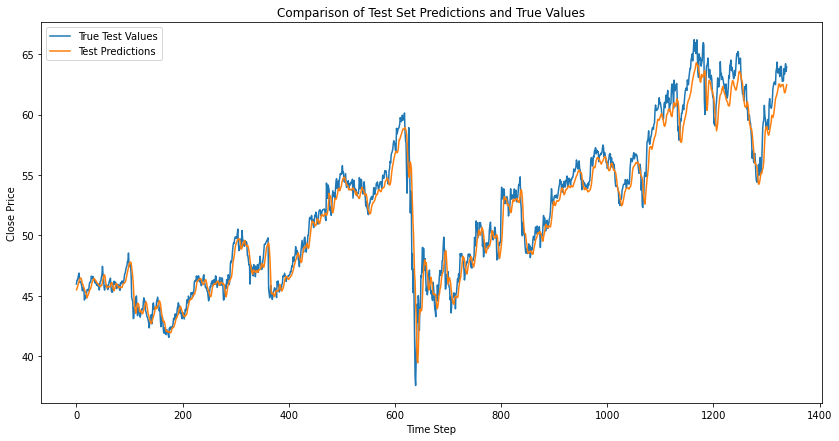

In [16]:
# Plot test predictions and actual values
plt.figure(figsize=(14,7))
plt.plot(y_test, label='True Test Values')
plt.plot(test_predict, label='Test Predictions')
plt.title('Comparison of Test Set Predictions and True Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, test_predict)
print(mse)

1.5321533632069508


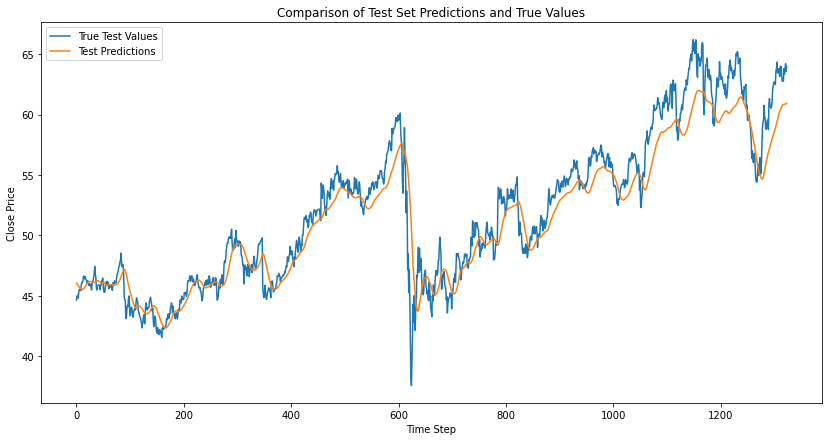

In [16]:
# Plot test predictions and actual values
plt.figure(figsize=(14,7))
plt.plot(y_test, label='True Test Values')
plt.plot(test_predict, label='Test Predictions')
plt.title('Comparison of Test Set Predictions and True Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, test_predict)
print(mse)

3.9571773111946165


#### Cross validation

The following function performs a time series cross validation of our LSTM model

In [32]:
from sklearn.model_selection import TimeSeriesSplit

def train_lstm(data, seq_length, n_splits=5):
    """
    Perform TimeSeries cross-validation on the LSTM model.
    
    Args:
    - data (pd.Series): The entire time series data.
    - seq_length (int): Length of input sequences.
    - n_splits (int): Number of splits for cross-validation.
    
    Returns:
    - history_list (list): List of training histories.
    - mse_values (list): List of mean squared errors for each fold.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    history_list = []
    mse_values = []

    for train_index, test_index in tscv.split(data):
        
        # Split the data into train and test sets for this fold
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]

        # Scale the training data for this fold and transform the test data
        scaler = MinMaxScaler(feature_range=(0,1))
        train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
        test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

        # Create sequences for this fold's scaled data
        X_train, y_train = create_sequences(pd.DataFrame(train_scaled), seq_length)
        X_test, y_test = create_sequences(pd.DataFrame(test_scaled), seq_length)
        
        # Adjust the shape for LSTM input
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        # Initialize and compile the LSTM model
        lstm_model = LSTMModel((X_train.shape[1], 1))
        lstm_model.model.compile(optimizer='adam', loss='mean_squared_error')

        checkpointer = ModelCheckpoint(
            filepath='weights_best.hdf5',
            verbose=2,
            save_best_only=True
        )

        # Train the model
        history = lstm_model.model.fit(
            X_train,
            y_train,
            validation_data=(X_test, y_test),
            epochs=25,
            batch_size=32,
            callbacks=[checkpointer]
        )

        history_list.append(history)

        # Use the trained model to predict on the test set
        predictions = lstm_model.model.predict(X_test)

        # Inverse transform the predictions and actual values
        y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))
        predictions_unscaled = scaler.inverse_transform(predictions)

        # Calculate MSE for this fold using unscaled data
        mse = mean_squared_error(y_test_unscaled, predictions_unscaled)
        mse_values.append(mse)

    return history_list, mse_values


# Each item in 'history_list' contains the training history for one fold.
# We can analyze these histories to assess the performance of the LSTM across different folds.


In [57]:
from sklearn.model_selection import TimeSeriesSplit

def train_lstm_cv(data, seq_length, model_function, n_splits=5):
    """
    Perform TimeSeries cross-validation on the LSTM model.
    
    Args:
    - data (pd.Series): The entire time series data.
    - seq_length (int): Length of input sequences.
    - model_function (function): A function to initialize and compile the LSTM model.
    - n_splits (int): Number of splits for cross-validation.
    
    Returns:
    - history_list (list): List of training histories.
    - mse_values (list): List of mean squared errors for each fold.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    history_list = []
    mse_values = []

    for train_index, test_index in tscv.split(data):
        
        # Split the data into train and test sets for this fold
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]

        # Scale the training data for this fold and transform the test data
        scaler = MinMaxScaler(feature_range=(0,1))
        train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
        test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

        # Create sequences for this fold's scaled data
        X_train, y_train = create_sequences(pd.DataFrame(train_scaled), seq_length)
        X_test, y_test = create_sequences(pd.DataFrame(test_scaled), seq_length)
        
        # Adjust the shape for LSTM input
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        # Use the provided model_function to get the model
        lstm_model = model_function((X_train.shape[1], 1))
        lstm_model.model.compile(optimizer='adam', loss='mean_squared_error')

        checkpointer = ModelCheckpoint(
            filepath='weights_best.hdf5',
            verbose=2,
            save_best_only=True
        )

        # Train the model
        history = lstm_model.model.fit(
            X_train,
            y_train,
            validation_data=(X_test, y_test),
            epochs=25,
            batch_size=32,
            callbacks=[checkpointer]
        )

        history_list.append(history)

        # Use the trained model to predict on the test set
        predictions = lstm_model.model.predict(X_test)

        # Inverse transform the predictions and actual values
        y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))
        predictions_unscaled = scaler.inverse_transform(predictions)

        # Calculate MSE for this fold using unscaled data
        mse = mean_squared_error(y_test_unscaled, predictions_unscaled)
        mse_values.append(mse)

    return history_list, mse_values


# Each item in 'history_list' contains the training history for one fold.
# We can analyze these histories to assess the performance of the LSTM across different folds.


Let us perform the cross validation analysis on the train set:

In [33]:
history_list, mse_values, train_date_ranges = train_lstm(train['Close'], 60)

2023-08-14 23:59:08.405655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-14 23:59:08.408391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-14 23:59:08.410098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2023-08-14 23:59:09.008475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-14 23:59:09.010849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-14 23:59:09.012614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - ETA: 0s - loss: 0.0514

2023-08-14 23:59:17.792110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-14 23:59:17.794496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-14 23:59:17.796348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.02002, saving model to weights_best.hdf5
27/27 [==============================] - 10s 168ms/step - loss: 0.0514 - val_loss: 0.0200
Epoch 2/25
27/27 [==============================] - ETA: 0s - loss: 0.0109
Epoch 2: val_loss improved from 0.02002 to 0.00608, saving model to weights_best.hdf5
27/27 [==============================] - 3s 123ms/step - loss: 0.0109 - val_loss: 0.0061
Epoch 3/25
27/27 [==============================] - ETA: 0s - loss: 0.0078
Epoch 3: val_loss improved from 0.00608 to 0.00338, saving model to weights_best.hdf5
27/27 [==============================] - 3s 124ms/step - loss: 0.0078 - val_loss: 0.0034
Epoch 4/25
27/27 [==============================] - ETA: 0s - loss: 0.0070
Epoch 4: val_loss improved from 0.00338 to 0.00269, saving model to weights_best.hdf5
27/27 [==============================] - 3s 127ms/step - loss: 0.0070 - val_loss: 0.0027
Epoch 5/25
27/27 [==============================] - ETA: 0s - loss: 0.0075
Ep

2023-08-15 00:00:36.394247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:00:36.396533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:00:36.398346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 2s 33ms/step


2023-08-15 00:00:39.106427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:00:39.108045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:00:39.110127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2023-08-15 00:00:39.603272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:00:39.607084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:00:39.608835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

55/55 [==============================] - ETA: 0s - loss: 0.0202

2023-08-15 00:00:50.190364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:00:50.192650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:00:50.195403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.00061, saving model to weights_best.hdf5
55/55 [==============================] - 12s 121ms/step - loss: 0.0202 - val_loss: 6.0937e-04
Epoch 2/25
55/55 [==============================] - ETA: 0s - loss: 0.0064
Epoch 2: val_loss improved from 0.00061 to 0.00056, saving model to weights_best.hdf5
55/55 [==============================] - 6s 103ms/step - loss: 0.0064 - val_loss: 5.6085e-04
Epoch 3/25
55/55 [==============================] - ETA: 0s - loss: 0.0056
Epoch 3: val_loss improved from 0.00056 to 0.00048, saving model to weights_best.hdf5
55/55 [==============================] - 6s 102ms/step - loss: 0.0056 - val_loss: 4.7662e-04
Epoch 4/25
55/55 [==============================] - ETA: 0s - loss: 0.0047
Epoch 4: val_loss did not improve from 0.00048
55/55 [==============================] - 6s 101ms/step - loss: 0.0047 - val_loss: 5.5007e-04
Epoch 5/25
55/55 [==============================] - ETA: 0s - loss: 0.0043
Epoch 5: val_loss improve

2023-08-15 00:03:07.617943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:03:07.620152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:03:07.621942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 2s 33ms/step


2023-08-15 00:03:09.993411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:03:09.995776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:03:09.997518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2023-08-15 00:03:10.497138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:03:10.500051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:03:10.501917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

83/83 [==============================] - ETA: 0s - loss: 0.0123

2023-08-15 00:03:23.366285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:03:23.368604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:03:23.370422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.00127, saving model to weights_best.hdf5
83/83 [==============================] - 14s 111ms/step - loss: 0.0123 - val_loss: 0.0013
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 0.0037
Epoch 2: val_loss did not improve from 0.00127
83/83 [==============================] - 8s 97ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 0.0039
Epoch 3: val_loss did not improve from 0.00127
83/83 [==============================] - 8s 98ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 4/25
83/83 [==============================] - ETA: 0s - loss: 0.0033
Epoch 4: val_loss improved from 0.00127 to 0.00121, saving model to weights_best.hdf5
83/83 [==============================] - 8s 99ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 5/25
83/83 [==============================] - ETA: 0s - loss: 0.0028
Epoch 5: val_loss improved from 0.00121 to 0.00117, saving model to weights_best.hd

2023-08-15 00:06:42.400483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:06:42.404267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:06:42.406281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 3s 35ms/step


2023-08-15 00:06:46.090426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:06:46.092594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:06:46.094591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2023-08-15 00:06:46.693448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:06:46.695702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:06:46.699007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

111/111 [==============================] - ETA: 0s - loss: 0.0083

2023-08-15 00:07:03.208782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:07:03.212192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:07:03.215108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.00146, saving model to weights_best.hdf5
111/111 [==============================] - 18s 107ms/step - loss: 0.0083 - val_loss: 0.0015
Epoch 2/25
111/111 [==============================] - ETA: 0s - loss: 0.0035
Epoch 2: val_loss improved from 0.00146 to 0.00123, saving model to weights_best.hdf5
111/111 [==============================] - 11s 96ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 3/25
111/111 [==============================] - ETA: 0s - loss: 0.0027
Epoch 3: val_loss improved from 0.00123 to 0.00073, saving model to weights_best.hdf5
111/111 [==============================] - 11s 96ms/step - loss: 0.0027 - val_loss: 7.3464e-04
Epoch 4/25
111/111 [==============================] - ETA: 0s - loss: 0.0026
Epoch 4: val_loss improved from 0.00073 to 0.00062, saving model to weights_best.hdf5
111/111 [==============================] - 11s 97ms/step - loss: 0.0026 - val_loss: 6.1915e-04
Epoch 5/25
111/111 [==============================] - E

2023-08-15 00:11:21.738579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:11:21.740847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:11:21.742717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 2s 33ms/step


2023-08-15 00:11:24.409251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:11:24.411577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:11:24.413512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2023-08-15 00:11:24.918264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:11:24.922563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:11:24.925871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

139/139 [==============================] - ETA: 0s - loss: 0.0103

2023-08-15 00:11:43.523649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:11:43.526078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:11:43.527934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.00311, saving model to weights_best.hdf5
139/139 [==============================] - 21s 110ms/step - loss: 0.0103 - val_loss: 0.0031
Epoch 2/25
139/139 [==============================] - ETA: 0s - loss: 0.0039
Epoch 2: val_loss did not improve from 0.00311
139/139 [==============================] - 14s 104ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 3/25
139/139 [==============================] - ETA: 0s - loss: 0.0033
Epoch 3: val_loss improved from 0.00311 to 0.00186, saving model to weights_best.hdf5
139/139 [==============================] - 13s 95ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 4/25
139/139 [==============================] - ETA: 0s - loss: 0.0029
Epoch 4: val_loss improved from 0.00186 to 0.00101, saving model to weights_best.hdf5
139/139 [==============================] - 14s 102ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 5/25
139/139 [==============================] - ETA: 0s - loss: 0.0027
Epoch 5: val_loss did n

2023-08-15 00:17:07.681015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 00:17:07.683358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 00:17:07.685195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 2s 32ms/step


Let's compute the average MSE and standard deviation:

In [34]:
# Compute average MSE and its standard deviation
average_mse = np.mean(mse_values)
mse_std = np.std(mse_values)

print(f"Average MSE across all folds: {average_mse:.4f}")
print(f"MSE standard deviation: {mse_std:.4f}")

Average MSE across all folds: 0.5449
MSE standard deviation: 0.3235


From these values, and recalling that the MSE on the test set is around 1.6, we can conclude the following:

1. The LSTM model, on average, performed better during cross-validation compared to its performance on the test set.

2. There is a relatively moderate variability in the performance across the different folds, as indicated by the standard deviation of the MSE values being similar to the mean MSE of cross validation. This suggests that the model might be sensitive to the specific portions of the dataset it is trained on, which might be a sign of the model slightly overfitting to particular patterns in specific subsets of the data.

3. The higher MSE on the test set compared to the average cross-validation MSE might indicate overfitting, or it might reflect that the test set has some characteristics or patterns that were not present in the training data. This could be due to the drastic drop due to the onset of the COVID pandemic.

We can have a look at the mean on the different folds:

In [35]:
mse_values

[1.0304360185371215,
 0.12052432457869998,
 0.3037920087433442,
 0.5062657047624448,
 0.7633056278858295]

Indeed we observe a moderate variability in the performance on different folds. The MSE appears to follow a declining trend from the first fold (highers MSE) to the second fold (lowest MSE) with the highest MSE being approximately 8.5 times the lowest MSE, and then gradually increases from the second fold to the fifth. 

A higher MSE in the first fold could be indicating underfitting. Underfitting is especially plausible to happen in the first fold of a time series cross-validation for several reasons. One reason is limited data: in the first fold of a time series cross-validation, the training dataset is the smallest. If the initial segment of data is not sufficiently diverse, the model might not learn the underlying temporal structures effectively. Other reason is changing dynamics: if the time series data has non-stationary characteristics as in our case, the initial segments might not represent the later segments well. In such cases, a model trained on early data may underperform when tested on later segments.

The second fold (MSE: 0.1205) shows a significant drop in error. This indicates that the model performs much better on this segment. The error starts to increase gradually from the third fold onwards. The increasing error trend could be due to overfitting: the model is trained cumulatively on previous folds, so it might start memorizing the training data, thus reducing its ability to generalize on new data. Another reason could be a data behavior shift: the later parts of the data might contain different or more complex patterns than the earlier parts which the model has not seen before, increasing prediction errors.

The high test set MSE relative to the cross-validation MSEs might raise concerns about the model's generalization capabilities. This could be due to the test set containing different, more complex patterns, or it could be a sign that the model might be overfitting to the training data, hence performing poorly on unseen data.

Comparing the plots of the MSE on the train and validation sets for the different folds as a function of the epoch may shed light on this issue:

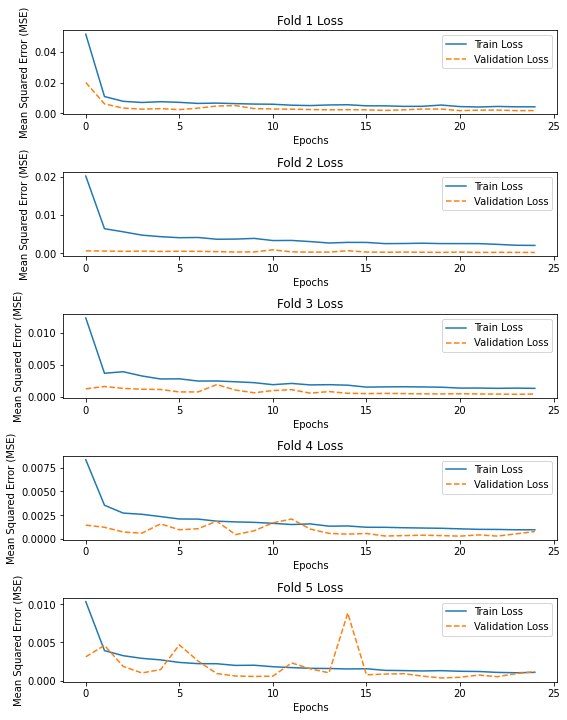

In [36]:
def plot_history(history_list):
    """
    Plot the training and validation loss across multiple histories.
    
    Args:
    - history_list (list): List of training histories.
    """
    plt.figure(figsize=(15, 10))
    
    # Iterate over each history item
    for index, history in enumerate(history_list, 1):
        plt.subplot(len(history_list), 2, 2*index - 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
        plt.title(f'Fold {index} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Squared Error (MSE)')
        plt.legend()
        
        # If you wish to also plot other metrics, for example accuracy (if used), you can do it in a similar manner:
        # plt.subplot(len(history_list), 2, 2*index)
        # plt.plot(history.history['accuracy'], label='Train Accuracy')
        # plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
        # plt.title(f'Fold {index} Accuracy')
        # plt.xlabel('Epochs')
        # plt.ylabel('Accuracy')
        # plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_history(history_list)

The higher value of MSE on the first fold along with the higher values of training and validation losses compared to the other folds suggests underfitting in this early step, at least in comparison with the later steps. 

Train and validation losses decrease subsequently until the fourth fold, where the validation loss curve has for the first time segments above the train loss curve. In the last fold train and validation losses have increased to the level of the third fold, and the validation loss curve has a few peaks above the train loss curve, with one value significantly higher. This succession suggests overfitting: the model is getting better at predicting the training data but worse at generalizing to new, unseen data.

As a conclusion of our cross-validation analysis we can expect our model to show slight overfitting. In order to take care of this issue, an additional step of further tuning the architecture and hyperparameters of the model would be needed, which we are not taking here.

#### Addressing overfitting

A modification of our previous LSTM model that reduces overfitting is introduced here. We implement L2 regularization for each layer and reduce the slide window (the number of past datapoints we use to create the seqeunces that re fed to the model) from 60 to 20. 

In [41]:
# Create sequences from train and test data
X_train, y_train = create_sequences(train_scaled['Close'], seq_length=20)
X_test, y_test = create_sequences(test_scaled['Close'], seq_length=20)

# Reshape the inputs to be suitable for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [42]:
from keras.regularizers import l2

class LSTMModel2:
    def __init__(self, input_shape, l2_reg_strength=0.05):
        self.input_shape = input_shape
        self.l2_reg_strength = l2_reg_strength
        
        # Call the '_build_model' method to construct the actual LSTM and store it in the 'self.model' attribute
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()

        # Using instance variable for regularization strength
        model.add(LSTM(units=50, return_sequences=True, input_shape=self.input_shape, 
                       kernel_regularizer=l2(self.l2_reg_strength), 
                       recurrent_regularizer=l2(self.l2_reg_strength)))
        model.add(Dropout(0.2))
        
        model.add(LSTM(units=50, 
                       kernel_regularizer=l2(self.l2_reg_strength), 
                       recurrent_regularizer=l2(self.l2_reg_strength)))
        model.add(Dropout(0.2))
        
        model.add(Dense(1))
        return model

In [43]:
# Print out a summary of the model
lstm_model = LSTMModel2((None, 1),l2_reg_strength=0.01)
lstm_model.model.summary()

2023-08-15 14:22:58.547928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 14:22:58.550177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 14:22:58.552369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, None, 50)          10400     
                                                                 
 dropout_38 (Dropout)        (None, None, 50)          0         
                                                                 
 lstm_39 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_39 (Dropout)        (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


2023-08-15 14:22:58.898009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 14:22:58.901220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 14:22:58.903951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [44]:
lstm_model.model.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
checkpointer = ModelCheckpoint(
    filepath = 'weights_best2.hdf5', 
    verbose = 2, 
    save_best_only = True
)


In [46]:
lstm_model.model.fit(
    X_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25


2023-08-15 14:23:15.423993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 14:23:15.427293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 14:23:15.430656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

168/168 [==============================] - 10s 26ms/step - loss: 0.5447
Epoch 2/25
168/168 [==============================] - 4s 24ms/step - loss: 0.0270
Epoch 3/25
168/168 [==============================] - 4s 24ms/step - loss: 0.0107
Epoch 4/25
168/168 [==============================] - 4s 24ms/step - loss: 0.0090
Epoch 5/25
168/168 [==============================] - 4s 26ms/step - loss: 0.0077
Epoch 6/25
168/168 [==============================] - 4s 25ms/step - loss: 0.0070
Epoch 7/25
168/168 [==============================] - 4s 25ms/step - loss: 0.0062
Epoch 8/25
168/168 [==============================] - 4s 25ms/step - loss: 0.0058
Epoch 9/25
168/168 [==============================] - 4s 26ms/step - loss: 0.0056
Epoch 10/25
168/168 [==============================] - 4s 26ms/step - loss: 0.0051
Epoch 11/25
168/168 [==============================] - 4s 25ms/step - loss: 0.0049
Epoch 12/25
168/168 [==============================] - 4s 25ms/step - loss: 0.0047
Epoch 13/25
168/168 [==

In [47]:
# Compute the predicted values on the test set
test_predict = lstm_model.model.predict(X_test)
# Undo the scaling transformation on the predicted values 'test_predict' and the actual test values 'y_test'
test_predict = scaler.inverse_transform(test_predict)


2023-08-15 14:25:35.729027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 14:25:35.732137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 14:25:35.734474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

42/42 [==============================] - 1s 10ms/step


In [48]:
y_test_reshaped = y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test_reshaped)

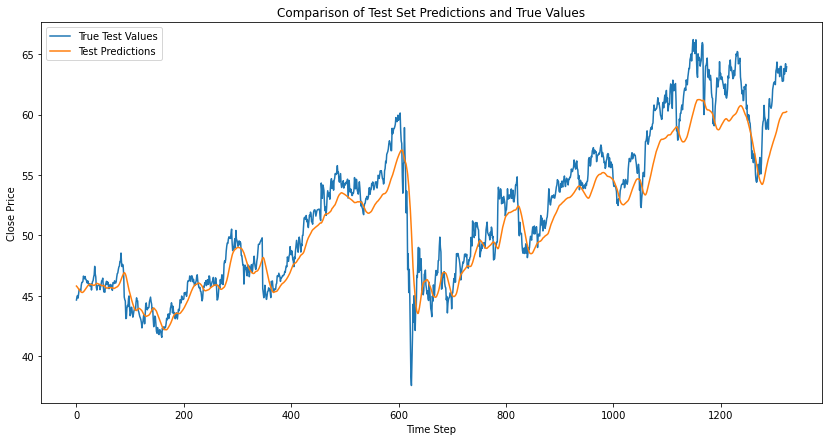

In [49]:
# Plot test predictions and actual values
plt.figure(figsize=(14,7))
plt.plot(y_test, label='True Test Values')
plt.plot(test_predict, label='Test Predictions')
plt.title('Comparison of Test Set Predictions and True Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [50]:
mse = mean_squared_error(y_test, test_predict)
print(mse)

4.9570389403395


In [61]:
history_list, mse_values = train_lstm_cv(train['Close'], 20, LSTMModel2)

2023-08-15 15:06:16.787905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:06:16.790642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:06:16.792533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2023-08-15 15:06:17.069995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:06:17.072258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:06:17.073970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - ETA: 0s - loss: 7.1146

2023-08-15 15:06:22.327532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:06:22.329830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:06:22.331713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 5.05153, saving model to weights_best.hdf5
28/28 [==============================] - 6s 64ms/step - loss: 7.1146 - val_loss: 5.0515
Epoch 2/25
28/28 [==============================] - ETA: 0s - loss: 3.8115
Epoch 2: val_loss improved from 5.05153 to 2.69361, saving model to weights_best.hdf5
28/28 [==============================] - 1s 37ms/step - loss: 3.8115 - val_loss: 2.6936
Epoch 3/25
27/28 [===========================>..] - ETA: 0s - loss: 2.0263
Epoch 3: val_loss improved from 2.69361 to 1.42779, saving model to weights_best.hdf5
28/28 [==============================] - 1s 38ms/step - loss: 2.0169 - val_loss: 1.4278
Epoch 4/25
26/28 [==========================>...] - ETA: 0s - loss: 1.0760
Epoch 4: val_loss improved from 1.42779 to 0.75901, saving model to weights_best.hdf5
28/28 [==============================] - 1s 37ms/step - loss: 1.0601 - val_loss: 0.7590
Epoch 5/25
28/28 [==============================] - ETA: 0s - loss: 0.5576
Epoch 5

2023-08-15 15:06:47.135811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:06:47.138029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:06:47.139825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - 1s 10ms/step


2023-08-15 15:06:48.346642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:06:48.348221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:06:48.350423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2023-08-15 15:06:48.592492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:06:48.594509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:06:48.596399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

54/56 [===========================>..] - ETA: 0s - loss: 5.4499

2023-08-15 15:06:53.897985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:06:53.900358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:06:53.902192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 2.62994, saving model to weights_best.hdf5
56/56 [==============================] - 6s 44ms/step - loss: 5.3794 - val_loss: 2.6299
Epoch 2/25
54/56 [===========================>..] - ETA: 0s - loss: 1.5228
Epoch 2: val_loss improved from 2.62994 to 0.72634, saving model to weights_best.hdf5
56/56 [==============================] - 2s 29ms/step - loss: 1.5030 - val_loss: 0.7263
Epoch 3/25
54/56 [===========================>..] - ETA: 0s - loss: 0.4204
Epoch 3: val_loss improved from 0.72634 to 0.20896, saving model to weights_best.hdf5
56/56 [==============================] - 2s 30ms/step - loss: 0.4149 - val_loss: 0.2090
Epoch 4/25
54/56 [===========================>..] - ETA: 0s - loss: 0.1265
Epoch 4: val_loss improved from 0.20896 to 0.06780, saving model to weights_best.hdf5
56/56 [==============================] - 2s 29ms/step - loss: 0.1251 - val_loss: 0.0678
Epoch 5/25
56/56 [==============================] - ETA: 0s - loss: 0.0510
Epoch 5

2023-08-15 15:07:34.749406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:07:34.753266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:07:34.755677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - 1s 9ms/step


2023-08-15 15:07:37.276712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:07:37.278848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:07:37.280721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2023-08-15 15:07:37.542284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:07:37.544692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:07:37.546552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/84 [============================>.] - ETA: 0s - loss: 4.2307

2023-08-15 15:07:43.671050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:07:43.673411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:07:43.675245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 1.34626, saving model to weights_best.hdf5
84/84 [==============================] - 7s 38ms/step - loss: 4.1820 - val_loss: 1.3463
Epoch 2/25
82/84 [============================>.] - ETA: 0s - loss: 0.6148
Epoch 2: val_loss improved from 1.34626 to 0.19225, saving model to weights_best.hdf5
84/84 [==============================] - 2s 28ms/step - loss: 0.6078 - val_loss: 0.1922
Epoch 3/25
82/84 [============================>.] - ETA: 0s - loss: 0.1001
Epoch 3: val_loss improved from 0.19225 to 0.04050, saving model to weights_best.hdf5
84/84 [==============================] - 2s 28ms/step - loss: 0.0992 - val_loss: 0.0405
Epoch 4/25
83/84 [============================>.] - ETA: 0s - loss: 0.0313
Epoch 4: val_loss improved from 0.04050 to 0.01894, saving model to weights_best.hdf5
84/84 [==============================] - 2s 28ms/step - loss: 0.0313 - val_loss: 0.0189
Epoch 5/25
82/84 [============================>.] - ETA: 0s - loss: 0.0192
Epoch 5

2023-08-15 15:08:41.512507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:08:41.516172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:08:41.519567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - 1s 10ms/step


2023-08-15 15:08:42.923987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:08:42.925636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:08:42.927847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2023-08-15 15:08:43.205741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:08:43.208134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:08:43.209971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

112/112 [==============================] - ETA: 0s - loss: 3.4398

2023-08-15 15:08:49.989792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:08:49.992159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:08:49.993973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.79100, saving model to weights_best.hdf5
112/112 [==============================] - 7s 35ms/step - loss: 3.4398 - val_loss: 0.7910
Epoch 2/25
110/112 [============================>.] - ETA: 0s - loss: 0.2706
Epoch 2: val_loss improved from 0.79100 to 0.09845, saving model to weights_best.hdf5
112/112 [==============================] - 3s 27ms/step - loss: 0.2681 - val_loss: 0.0984
Epoch 3/25
112/112 [==============================] - ETA: 0s - loss: 0.0398
Epoch 3: val_loss improved from 0.09845 to 0.03706, saving model to weights_best.hdf5
112/112 [==============================] - 3s 27ms/step - loss: 0.0398 - val_loss: 0.0371
Epoch 4/25
111/112 [============================>.] - ETA: 0s - loss: 0.0181
Epoch 4: val_loss improved from 0.03706 to 0.01792, saving model to weights_best.hdf5
112/112 [==============================] - 3s 27ms/step - loss: 0.0180 - val_loss: 0.0179
Epoch 5/25
110/112 [============================>.] - ETA: 0s - loss

2023-08-15 15:10:03.480471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:10:03.482885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:10:03.484760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - 1s 9ms/step


2023-08-15 15:10:04.966041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:10:04.967627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:10:04.969653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2023-08-15 15:10:05.257206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:10:05.259530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:10:05.261301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

138/140 [============================>.] - ETA: 0s - loss: 2.8829

2023-08-15 15:10:12.606134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:10:12.608656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:10:12.610436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.41690, saving model to weights_best.hdf5
140/140 [==============================] - 8s 32ms/step - loss: 2.8573 - val_loss: 0.4169
Epoch 2/25
138/140 [============================>.] - ETA: 0s - loss: 0.1318
Epoch 2: val_loss improved from 0.41690 to 0.05120, saving model to weights_best.hdf5
140/140 [==============================] - 4s 26ms/step - loss: 0.1309 - val_loss: 0.0512
Epoch 3/25
139/140 [============================>.] - ETA: 0s - loss: 0.0254
Epoch 3: val_loss improved from 0.05120 to 0.02982, saving model to weights_best.hdf5
140/140 [==============================] - 4s 26ms/step - loss: 0.0254 - val_loss: 0.0298
Epoch 4/25
140/140 [==============================] - ETA: 0s - loss: 0.0155
Epoch 4: val_loss improved from 0.02982 to 0.01963, saving model to weights_best.hdf5
140/140 [==============================] - 4s 26ms/step - loss: 0.0155 - val_loss: 0.0196
Epoch 5/25
139/140 [============================>.] - ETA: 0s - loss

2023-08-15 15:11:42.092450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 15:11:42.095373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 15:11:42.097701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - 1s 10ms/step


In [ ]:
The average MSE and standard deviation are:

In [62]:
# Compute average MSE and its standard deviation
average_mse = np.mean(mse_values)
mse_std = np.std(mse_values)

print(f"Average MSE across all folds: {average_mse:.4f}")
print(f"MSE standard deviation: {mse_std:.4f}")

Average MSE across all folds: 1.8166
MSE standard deviation: 1.2340


A relatively moderate variability in the performance across the different folds is still present, as the standard deviation of the MSE values is similar to the mean MSE (although less similar then in the previous model). This suggests that our new model is still sensitive to the specific portions of the dataset it is trained on, but this sensitivity has been slightly reduced.

In [63]:
mse_values

[3.502793075609179,
 0.8604588615507901,
 0.9285752815975159,
 0.6596759193685302,
 3.131611886168382]

The individual values of the MSE for different folds seem more similar among themselves, with the largest one (3.5) being around 5 times the smallest one (0.65), which is also a reduction compared to the previous model. 

Still, this variability might be due to overfitting. Again, a look at the train loss versus validation loss plots sheds light on the issue.

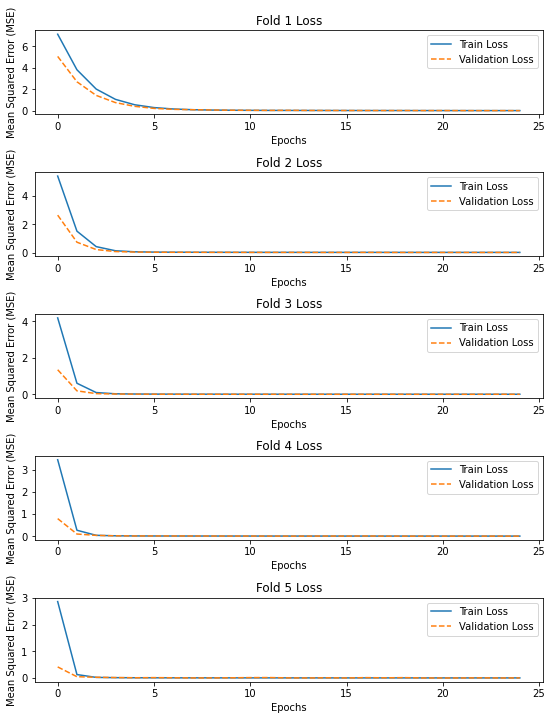

In [64]:
def plot_history(history_list):
    """
    Plot the training and validation loss across multiple histories.
    
    Args:
    - history_list (list): List of training histories.
    """
    plt.figure(figsize=(15, 10))
    
    # Iterate over each history item
    for index, history in enumerate(history_list, 1):
        plt.subplot(len(history_list), 2, 2*index - 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
        plt.title(f'Fold {index} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Squared Error (MSE)')
        plt.legend()
        
        # If you wish to also plot other metrics, for example accuracy (if used), you can do it in a similar manner:
        # plt.subplot(len(history_list), 2, 2*index)
        # plt.plot(history.history['accuracy'], label='Train Accuracy')
        # plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
        # plt.title(f'Fold {index} Accuracy')
        # plt.xlabel('Epochs')
        # plt.ylabel('Accuracy')
        # plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_history(history_list)

The validation loss curve is always under the train loss curve. This demonstrates that our second model addresses overfitting satisfactorily. The variability on the different cross validation folds seems to be due to the time series data showing different behaviors, noise, and patterns that cannot be learned from previous folds. This is particularly likely in the case of a non-stationary time series as ours.

In general, whether to include or not corrections to prevent overfitting will depend on the specific application and time scale we have in mind. For instance, it seems reasonable to reduce overfitting for prediction over long periods of time. However, in the short term we might be more interested in obtaining a prediction that better captures noise.

#### Multivariate LSTM

We shall now explore the effect of adding extra features to our model. We must keep in mind that introducing additional features to an LSTM model can lead to a variety of outcomes, and the effect on the model's performance is not necessarily predictable. Namely, adding more features does not always guarantee improved performance. 

The multivariate case requires some modifications to our previous code. We define a new function for the train/test split and scaling where a subset of features has been selected:

In [56]:

def scale_dataframe_m(filename):
    # Load data into DataFrame 
    df = pd.read_csv(filename, parse_dates=True, index_col=0)

    df = df[['Close', 'Open', 'High', 'Reported EPS']]

    # Compute the number of data points for 80% of the data
    train_size = int(0.8 * len(df))

    # Split into train and test sets
    train = df[:train_size]
    test = df[train_size:]

    # Scale the entire dataset (all features, including 'Close')
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)

    # Return all relevant data
    return df, train, test, train_scaled, test_scaled, scaler

df, train, test, train_scaled, test_scaled, scaler = scale_dataframe_m('df_KO_.csv')





The `create_sequences` function needs to be slightly modified so we are cerating sequences of the selected features, not just for `Close`. HOwever, since we are only interested in predicting `Close`, the labels `ys` will only correspond to this variable. 

In [57]:
def create_sequences_m(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data.iloc[i:(i+seq_length)].values
        y = data.iloc[i+seq_length]["Close"]  # Target remains the "Close" value
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)



In [58]:
seq_length = 60

In [59]:
# Create sequences from train and test data
X_train, y_train = create_sequences_m(train_scaled, seq_length)
X_test, y_test = create_sequences_m(test_scaled, seq_length)

Note that in the multivariate case, if the `create_sequences` function is handling multivariate data appropriately, there is no need to explicitly reshape the resulting `X_train` and `X_test` sequences: they should already be in the correct shape.

On the other hand, we will have to modify the code defining the class of our model to take into account the multiple number of features.

In [60]:

class LSTMModel3:
    def __init__(self, input_shape, l2_reg_strength=0.05):
        self.input_shape = input_shape
        self.l2_reg_strength = l2_reg_strength
        
        # Call the '_build_model' method to construct the actual LSTM and store it in the 'self.model' attribute
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()

        # Using instance variable for regularization strength
        model.add(LSTM(units=50, return_sequences=True, input_shape=self.input_shape, 
                       kernel_regularizer=l2(self.l2_reg_strength), 
                       recurrent_regularizer=l2(self.l2_reg_strength)))
        model.add(Dropout(0.2))

        model.add(LSTM(units=50, 
                       kernel_regularizer=l2(self.l2_reg_strength), 
                       recurrent_regularizer=l2(self.l2_reg_strength)))
        model.add(Dropout(0.2))
        
        model.add(Dense(1))
        return model

`train_scaled.shape[1]` captures the number of features, and we shall pass it to the `input_shape`:

In [61]:
input_shape = (seq_length, train_scaled.shape[1])

In [62]:
lstm_model = LSTMModel3(input_shape=input_shape)
lstm_model.model.summary()

2023-08-15 18:52:21.381628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 18:52:21.383973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 18:52:21.385741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            11000     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31,251
Trainable params: 31,251
Non-trainable params: 0
_________________________________________________________________


2023-08-15 18:52:21.647212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 18:52:21.649435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 18:52:21.651288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [63]:
lstm_model.model.compile(optimizer='adam', loss='mean_squared_error')

In [64]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint(
    filepath = 'weights_best_m.hdf5', 
    verbose = 2, 
    save_best_only = True
)

In [65]:
lstm_model.model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size = 64,
    callbacks = [checkpointer]
)

Epoch 1/50


2023-08-15 18:52:24.378280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 18:52:24.380750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 18:52:24.382770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

83/83 [==============================] - 10s 78ms/step - loss: 4.4708
Epoch 2/50
83/83 [==============================] - 6s 76ms/step - loss: 0.6883
Epoch 3/50
83/83 [==============================] - 6s 76ms/step - loss: 0.1123
Epoch 4/50
83/83 [==============================] - 6s 77ms/step - loss: 0.0325
Epoch 5/50
83/83 [==============================] - 6s 76ms/step - loss: 0.0190
Epoch 6/50
83/83 [==============================] - 6s 76ms/step - loss: 0.0141
Epoch 7/50
83/83 [==============================] - 6s 77ms/step - loss: 0.0112
Epoch 8/50
83/83 [==============================] - 6s 76ms/step - loss: 0.0096
Epoch 9/50
83/83 [==============================] - 7s 84ms/step - loss: 0.0088
Epoch 10/50
83/83 [==============================] - 7s 79ms/step - loss: 0.0081
Epoch 11/50
83/83 [==============================] - 7s 79ms/step - loss: 0.0076
Epoch 12/50
83/83 [==============================] - 7s 85ms/step - loss: 0.0075
Epoch 13/50
83/83 [============================

In [66]:
# Compute the predicted values on the test set
test_predict = lstm_model.model.predict(X_test)

2023-08-15 18:58:01.024924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-15 18:58:01.027068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-15 18:58:01.029196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

41/41 [==============================] - 2s 23ms/step


In order to undo the scaling transformation on our predictions, we have to keep in mind that the scaling was done for multiple features, not just the `Close` column as in the univariate case. We need to have an array with the same shape as the original dataset and pass it to the scaler. So we will create a dummy array filled with zeros with the right shape, with the column corresponding to our predictions in the same position as the `Close` column in our dataset.

In [67]:
# Create a dummy array filled with zeros, but same shape as original dataset
dummy_array = np.zeros((test_predict.shape[0], 4))

# Fill the column corresponding to 'Close' with test_predict values.
dummy_array[:, 0] = test_predict[:, 0]

# Use inverse_transform
unscaled_array = scaler.inverse_transform(dummy_array)

# Extract unscaled predictions for 'Close'
test_predict_original = unscaled_array[:, 0]

We follow the same steps for unscaling the actual values of `Close` on the test set, taking into account that a reshape to a 2D array is needed:

In [68]:
y_test_reshaped = y_test.reshape(-1, 1)

# Create a dummy array filled with zeros of the right shape
dummy_array = np.zeros((y_test_reshaped.shape[0], 4))

# Fill the column corresponding to 'Close' with y_test_reshaped values
dummy_array[:, 0] = y_test_reshaped[:, 0]

# Use inverse_transform
unscaled_array = scaler.inverse_transform(dummy_array)

# Extract the unscaled values for 'Close'
y_test_unscaled = unscaled_array[:, 0]


We are now in busineess to plot our predictions versus actual values of `Close` on the test set.

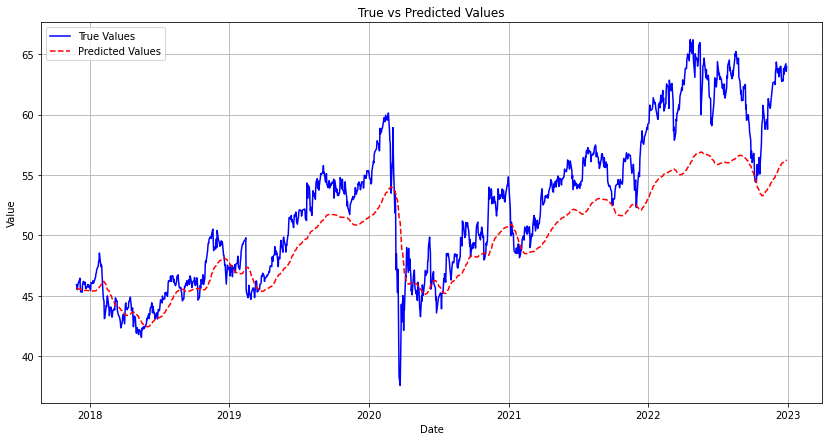

In [69]:
# Extract the date-time index for the test set
test_dates = test.index

offset_test_dates = test_dates[seq_length:]
offset_test_dates = offset_test_dates[:-1]

# Plot the true values
plt.figure(figsize=(14, 7))
plt.plot(offset_test_dates, y_test_unscaled, label="True Values", color='blue')

# Plot the predicted values
plt.plot(offset_test_dates, test_predict_original, label="Predicted Values", color='red', linestyle='dashed')

plt.title("True vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [70]:
mse = mean_squared_error(y_test_unscaled, test_predict_original)
print(mse)

14.250616749049216


The introduction of new features seem to actually worsen the performance of our model. Some general reasons underlying this phenomenon are:

Added Noise: Some added features might introduce noise or collinearity which can confuse the model and degrade performance.

Need for a more complex model: A simple model that worked well for univariate data might not suffice to capture all the relationships between features and target for multivariate data.

Temporal Dynamics: In a multivariate setting we are also considering other features' past values aside from the target. If these extra features do not have a clear and consistent temporal relationship with the target, it can lead to errors.

An additional study to determine the actual causes of this worsening upon introduction of additional features is out of the scope of this work. We can nevertheless mention that the rather low volatility of our stock and the relatively good results obtained from the univariate case might already be pointing out that it might not be necessary to consider extra features.

### 2. Tesla stock

#### Univariate model

In [31]:
df, train, test, train_scaled, test_scaled, scaler = scale_dataframe('TSLA.csv')

In [32]:
# Create sequences from train and test data
X_train, y_train = create_sequences(train_scaled['Close'], seq_length)
X_test, y_test = create_sequences(test_scaled['Close'], seq_length)

In [33]:
# Reshape the inputs to be suitable for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [34]:
lstm_model2 = LSTMModel((None, 1))

2023-08-08 13:40:48.605346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-08 13:40:48.609070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-08 13:40:48.611708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [35]:
lstm_model2.model.compile(optimizer='adam', loss='mean_squared_error')

In [36]:
checkpointer2 = ModelCheckpoint(
    filepath = 'weights_best2.hdf5', 
    verbose = 2, 
    save_best_only = True
)


In [37]:
lstm_model2.model.fit(
    X_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [checkpointer2]
)

Epoch 1/25


2023-08-08 13:40:49.570265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-08 13:40:49.572777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-08 13:40:49.574813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 13s 88ms/step - loss: 0.0037
Epoch 2/25
77/77 [==============================] - 7s 88ms/step - loss: 0.0013
Epoch 3/25
77/77 [==============================] - 7s 88ms/step - loss: 9.1475e-04
Epoch 4/25
77/77 [==============================] - 7s 88ms/step - loss: 8.6018e-04
Epoch 5/25
77/77 [==============================] - 7s 90ms/step - loss: 0.0011
Epoch 6/25
77/77 [==============================] - 7s 90ms/step - loss: 9.0260e-04
Epoch 7/25
77/77 [==============================] - 7s 88ms/step - loss: 7.8808e-04
Epoch 8/25
77/77 [==============================] - 7s 90ms/step - loss: 6.8743e-04
Epoch 9/25
77/77 [==============================] - 7s 89ms/step - loss: 6.8387e-04
Epoch 10/25
77/77 [==============================] - 7s 90ms/step - loss: 6.9399e-04
Epoch 11/25
77/77 [==============================] - 7s 91ms/step - loss: 6.3767e-04
Epoch 12/25
77/77 [==============================] - 7s 88ms/step - loss: 5.4307e-04
Epoch 13/25

In [38]:
# Compute the predicted values on the test set
test_predict = lstm_model2.model.predict(X_test)

# Undo the scaling transformation on the predicted values 'test_predict' and the actual test values 'y_test'
test_predict = scaler.inverse_transform(test_predict)

2023-08-08 13:43:48.103192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-08 13:43:48.105401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-08 13:43:48.107121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

18/18 [==============================] - 2s 33ms/step


In [39]:
y_test_reshaped = y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test_reshaped)

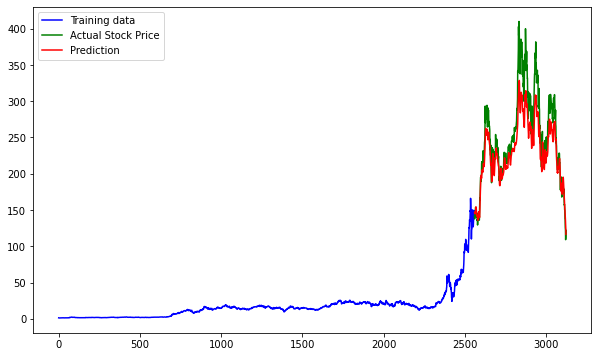

In [40]:
plt.figure(figsize=(10,6))
plt.plot(df.index[:len(train)+seq_length], df['Close'][:len(train)+seq_length], color='blue', label='Training data')
plt.plot(df.index[len(train)+seq_length:-1], df['Close'][len(train)+seq_length:-1], color='green', label='Actual Stock Price')
plt.plot(df.index[len(train)+seq_length:-1], test_predict, color='red', label='Prediction')
plt.legend()
plt.show()

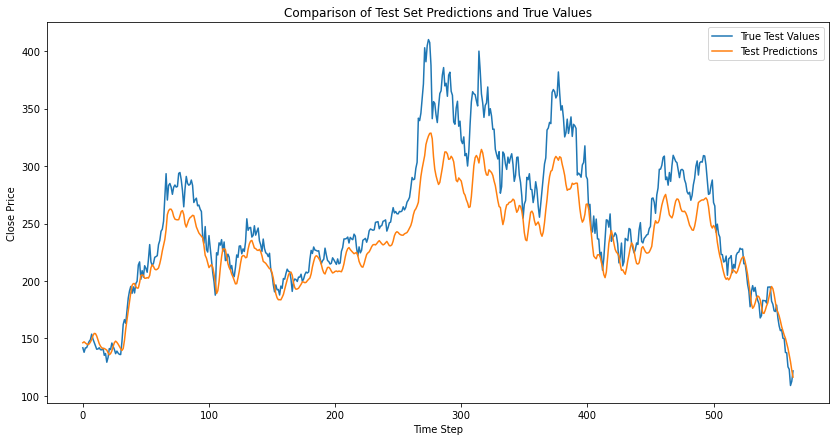

In [41]:
# Plot test predictions and actual values
plt.figure(figsize=(14,7))
plt.plot(y_test, label='True Test Values')
plt.plot(test_predict, label='Test Predictions')
plt.title('Comparison of Test Set Predictions and True Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [42]:

mse = mean_squared_error(y_test, test_predict)
print(mse)

898.7467357423725


#### Multivariate model

In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# This function reads our csv file and returns the dataframe, train set, test set, scaled train set, scaled test set and scaler

def scale_dataframe(filename):
    # Load data into DataFrame 
    df = pd.read_csv(filename, parse_dates=True, index_col=0)

    df = df[['Close', 'Open','Reported EPS']]

    # Compute the number of data points for 80% of the data
    train_size = int(0.8 * len(df))

    # Split into train and test sets
    train = df[:train_size]
    test = df[train_size:]

    # Scale the entire dataset (all features, including 'Close')
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)

    # Return all relevant data
    return df, train, test, train_scaled, test_scaled, scaler

df, train, test, train_scaled, test_scaled, scaler = scale_dataframe('df_TSLA_.csv')

In [7]:
class LSTMModel:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        
        model.add(LSTM(units=100, return_sequences=True, input_shape=self.input_shape))
        model.add(Dropout(0.2))

        model.add(LSTM(units=100, return_sequences=True))
        model.add(Dropout(0.2))
        
        model.add(LSTM(units=100))
        model.add(Dropout(0.2))

        model.add(Dense(units=1))
       # model.add(Dropout(0.2))

        return model

In [11]:
lstm_model.model.fit(
    X_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25


2023-08-12 19:16:37.272176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-12 19:16:37.274615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-12 19:16:37.276533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

76/76 [==============================] - 20s 170ms/step - loss: 0.0033
Epoch 2/25
76/76 [==============================] - 13s 172ms/step - loss: 9.2899e-04
Epoch 3/25
76/76 [==============================] - 13s 177ms/step - loss: 8.0596e-04
Epoch 4/25
76/76 [==============================] - 12s 153ms/step - loss: 6.6025e-04
Epoch 5/25
76/76 [==============================] - 12s 158ms/step - loss: 7.2432e-04
Epoch 6/25
76/76 [==============================] - 11s 151ms/step - loss: 8.0254e-04
Epoch 7/25
76/76 [==============================] - 12s 152ms/step - loss: 5.9339e-04
Epoch 8/25
76/76 [==============================] - 12s 152ms/step - loss: 5.0126e-04
Epoch 9/25
76/76 [==============================] - 12s 153ms/step - loss: 4.6922e-04
Epoch 10/25
76/76 [==============================] - 12s 153ms/step - loss: 4.2984e-04
Epoch 11/25
76/76 [==============================] - 12s 161ms/step - loss: 4.8927e-04
Epoch 12/25
76/76 [==============================] - 13s 174ms/step

In [12]:
# Compute the predicted values on the test set
test_predict = lstm_model.model.predict(X_test)

2023-08-12 19:21:59.966101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-12 19:21:59.968885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-12 19:21:59.971422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

18/18 [==============================] - 2s 69ms/step


In [13]:
# Step 1: Create a dummy array filled with zeros, but same shape as original dataset
dummy_array = np.zeros((test_predict.shape[0], 3))

# Step 2: Fill the column corresponding to 'Close' with test_predict values.
# Let's assume 'Close' was the first column; adjust the index accordingly if it's different.
dummy_array[:, 0] = test_predict[:, 0]

# Step 3: Use inverse_transform
unscaled_array = scaler.inverse_transform(dummy_array)

# Step 4: Extract unscaled predictions for 'Close'
test_predict_original = unscaled_array[:, 0]

In [14]:
y_test_reshaped = y_test.reshape(-1, 1)
# Create a dummy array filled with zeros of shape (y_test_reshaped.shape[0], 18)
dummy_array = np.zeros((y_test_reshaped.shape[0], 3))

# Fill the column corresponding to your feature of interest (e.g., 'Close') with y_test_reshaped values.
# Assuming 'Close' was the first column; adjust the index if it's different.
dummy_array[:, 0] = y_test_reshaped[:, 0]

# Use inverse_transform on the dummy array
unscaled_array = scaler.inverse_transform(dummy_array)

# Extract the unscaled values for 'Close' (or your feature of interest)
y_test_unscaled = unscaled_array[:, 0]

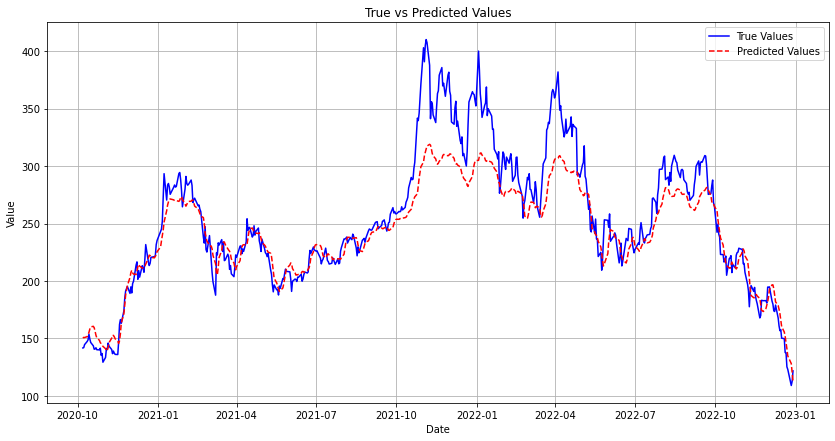

In [16]:
import matplotlib.pyplot as plt

# Extract the date-time index for the test set
test_dates = test.index

offset_test_dates = test_dates[seq_length:]

offset_test_dates = offset_test_dates[:-1]

# Plot the true values
plt.figure(figsize=(14, 7))
plt.plot(offset_test_dates, y_test_unscaled, label="True Values", color='blue')

# Plot the predicted values
plt.plot(offset_test_dates, test_predict_original, label="Predicted Values", color='red', linestyle='dashed')

plt.title("True vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

f[['Close', 'Open', 'Reported EPS', 'High']]


In [17]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_unscaled, test_predict_original)
print(mse)

623.7497645471066


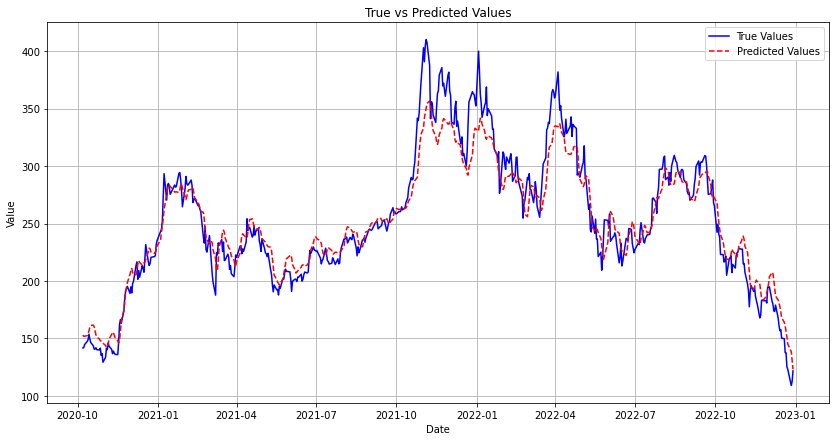

In [18]:
import matplotlib.pyplot as plt

# Extract the date-time index for the test set
test_dates = test.index

offset_test_dates = test_dates[seq_length:]

offset_test_dates = offset_test_dates[:-1]

# Plot the true values
plt.figure(figsize=(14, 7))
plt.plot(offset_test_dates, y_test_unscaled, label="True Values", color='blue')

# Plot the predicted values
plt.plot(offset_test_dates, test_predict_original, label="Predicted Values", color='red', linestyle='dashed')

plt.title("True vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_unscaled, test_predict_original)
print(mse)

301.6240034465739


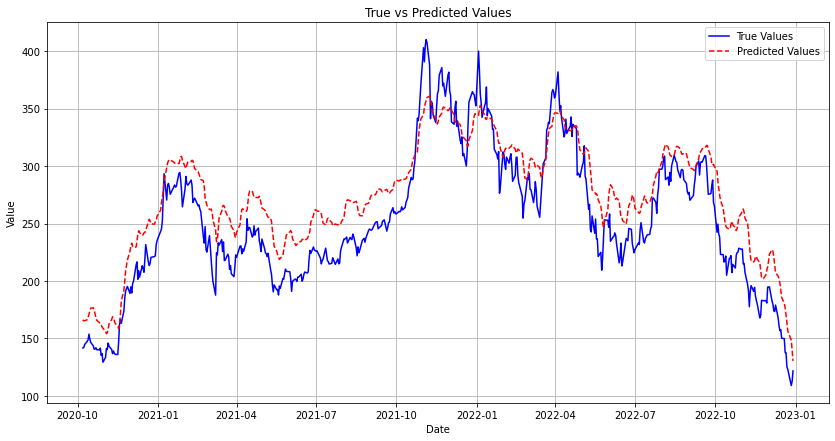

In [16]:
import matplotlib.pyplot as plt

# Extract the date-time index for the test set
test_dates = test.index

offset_test_dates = test_dates[seq_length:]

offset_test_dates = offset_test_dates[:-1]

# Plot the true values
plt.figure(figsize=(14, 7))
plt.plot(offset_test_dates, y_test_unscaled, label="True Values", color='blue')

# Plot the predicted values
plt.plot(offset_test_dates, test_predict_original, label="Predicted Values", color='red', linestyle='dashed')

plt.title("True vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

'Close', 'Open','High'


In [17]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_unscaled, test_predict_original)
print(mse)

821.1848196917397


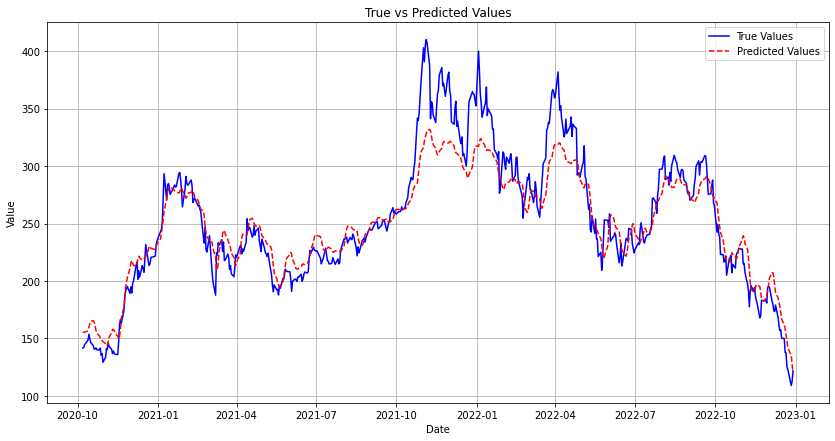

In [15]:
import matplotlib.pyplot as plt

# Extract the date-time index for the test set
test_dates = test.index

offset_test_dates = test_dates[seq_length:]

offset_test_dates = offset_test_dates[:-1]

# Plot the true values
plt.figure(figsize=(14, 7))
plt.plot(offset_test_dates, y_test_unscaled, label="True Values", color='blue')

# Plot the predicted values
plt.plot(offset_test_dates, test_predict_original, label="Predicted Values", color='red', linestyle='dashed')

plt.title("True vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_unscaled, test_predict_original)
print(mse)

464.32706744385877


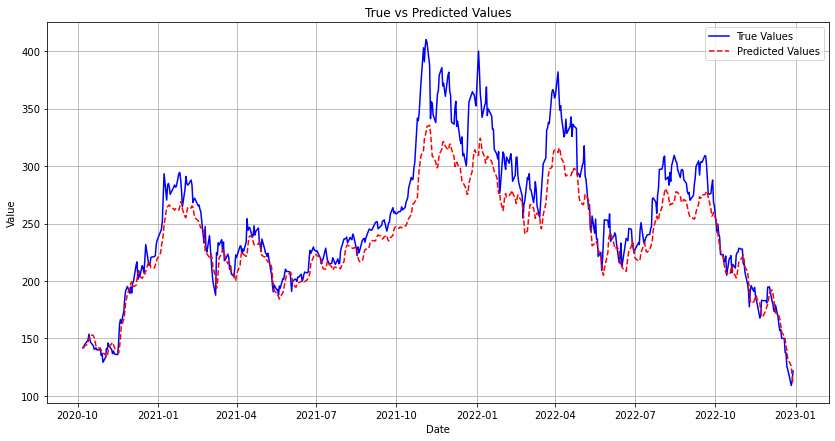

In [15]:
import matplotlib.pyplot as plt

# Extract the date-time index for the test set
test_dates = test.index

offset_test_dates = test_dates[seq_length:]

offset_test_dates = offset_test_dates[:-1]

# Plot the true values
plt.figure(figsize=(14, 7))
plt.plot(offset_test_dates, y_test_unscaled, label="True Values", color='blue')

# Plot the predicted values
plt.plot(offset_test_dates, test_predict_original, label="Predicted Values", color='red', linestyle='dashed')

plt.title("True vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


100

In [16]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_unscaled, test_predict_original)
print(mse)

622.6635170602559
